In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import datetime as dt
import json
import scipy as sp
from tqdm import tqdm
# from functions import bfs, find_closest_nodes, find_route, get_distance, get_way
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', 500)

In [3]:
import json

json_file_path = r"data/ways_with_points_cleared_5m_v2.json"
with open(json_file_path, 'r') as j:
    ways_with_points = json.loads(j.read())
    
json_file_path = r"data/way_with_neighbours.json"
with open(json_file_path, 'r') as j:
    ways_with_neighbours = json.loads(j.read())   
    
json_file_path = r"data/points_with_ways_new.json"
with open(json_file_path, 'r') as j:
    points_with_ways = json.loads(j.read())  

In [4]:
ways = np.array([int(i) for i in list(ways_with_neighbours.keys())])
lat1 = np.array([float(i.split(', ')[0]) for i in list(points_with_ways.keys())])
lon1 = np.array([float(i.split(', ')[1]) for i in list(points_with_ways.keys())])
point_names = list(points_with_ways.keys())
coordinates = np.vstack((lat1, lon1)).T#.shape

# bfs

In [5]:
def bfs(graph, start_node, end_node):
    
    visited = [] # List to keep track of visited nodes.
    queue = []     #Initialize a queue
    sequence = {}
    max_seq_len_exceeded = False
    
    visited.append(start_node)
    queue.append(start_node)
    
    current_node = start_node
    sequence[current_node] = [current_node]
    
    while current_node != end_node:
        if (len(queue) == 0) or (max_seq_len_exceeded):
            return []
        current_node = queue.pop(0)
        #print (current_node, graph[current_node],  visited) 
        for neighbour in graph[current_node]:
            
            
            if neighbour == end_node:
                #print('fin', sequence[current_node]+[neighbour])
                sequence[neighbour] = sequence[current_node]+[neighbour]
                current_node = neighbour
                    
            elif neighbour not in visited and neighbour in graph.keys():
                #print('ok', neighbour)
                visited.append(neighbour)
#                 print('Путь', neighbour,'его соседи', graph[neighbour],'посещены ли они уже', [(i in visited) for i in graph[neighbour]])
                sequence[neighbour] = sequence[current_node]+[neighbour]
                if len(sequence[neighbour]) > 100:
                    max_seq_len_exceeded = True

                queue.append(neighbour)
                
#             for way0 in visited:
#                 way = ways_with_points[way0]
#                 lat, lon = [float(x.split(', ')[0]) for x in way], [float(x.split(', ')[1]) for x in way]
#                 #print(way0,way)
#                 plt.plot(lat,lon)
#                 plt.title("Все участки")
#             plt.show()
    
    return sequence[current_node]

# find closest nodes

In [6]:
def find_closest_nodes(start_point, end_point):
    
    start_n  = np.argmin(np.linalg.norm(coordinates - start_point, axis=1))
    end_n    = np.argmin(np.linalg.norm(coordinates - end_point, axis=1))
    start_point = point_names[start_n]
    end_point   = point_names[end_n]
    
    return points_with_ways[start_point][0], points_with_ways[end_point][0], start_point, end_point


# find route

In [7]:
def find_route(start_point, end_point, ways_with_nodes):   
    
    start_way, end_way, start_node, end_node = find_closest_nodes(start_point, end_point)
    
    if get_distance(float(start_node.split(',')[0]), float(start_node.split(',')[1]), 
                    float(end_node.split(',')[0]), float(end_node.split(',')[1])) < 0.1:
        return 'it is idle', [], [], [] # проверка на то, что между ними 100 метров
    
    if start_way == end_way:
        one_way = start_way
        our_one_way_nodes = ways_with_nodes[start_way]
        start_point_index = our_one_way_nodes.index(start_node)
        end_point_index = our_one_way_nodes.index(start_node)
        
        if start_point_index < end_point_index:
            nodes_on_route = our_one_way_nodes[start_point_index:end_point_index+1]
        else:
            nodes_on_route = our_one_way_nodes[end_point_index:start_point_index+1][::-1]
            
        return nodes_on_route, [one_way], [1]*len(nodes_on_route), []
        
    #print('1-2')    
    way_on_route = bfs(ways_with_neighbours, start_way, end_way)
    
    # получили список путей
    if len(way_on_route) == 0:
        return 'it is not bound points', [], [], []
    
    nodes_on_route = []
    colors_for_ways = []
    
    intersect = start_node
    intersects = []
    #print('2-2')
    for i in range(1,len(way_on_route)):
        # найдем индекс в старом и новом путях
        previous_way_nodes = ways_with_nodes[way_on_route[i-1]]
        next_way_nodes = ways_with_nodes[way_on_route[i]]
        
        # найдем пересечение нового со старым
        new_intersect = [j for j in previous_way_nodes if j in next_way_nodes][0] 
        #print('intersection:',way_on_route[i-1], [j for j in previous_way_nodes if j in next_way_nodes])
        
        pr_start_index = previous_way_nodes.index(intersect)
        pr_end_index = previous_way_nodes.index(new_intersect)
 
        if pr_start_index < pr_end_index:
            additional_nodes = previous_way_nodes[pr_start_index:pr_end_index+1]
        else:          
            additional_nodes = previous_way_nodes[pr_end_index:pr_start_index+1][::-1]
        
        intersect = new_intersect
        intersects.append(intersect)
        
        nodes_on_route += additional_nodes    
        colors_for_ways += [way_on_route[i-1]]*len(additional_nodes)

    pr_start_index = next_way_nodes.index(intersect)
    pr_end_index = next_way_nodes.index(end_node)        
    if pr_start_index < pr_end_index:
        additional_nodes = next_way_nodes[pr_start_index:pr_end_index+1]
    else:
        additional_nodes = next_way_nodes[pr_end_index:pr_start_index+1][::-1]
        
    old_way_on_route = way_on_route[0]
    nodes_on_route += additional_nodes 
    colors_for_ways += [way_on_route[i]]*len(additional_nodes)
    
    return nodes_on_route, way_on_route, colors_for_ways, intersects

# get distance

In [8]:
def get_distance(lat1, lon1, lat2, lon2):
    
    import numpy as np
    lat1 = np.radians(lat1)
    lon1 = np.radians(lon1)
    lat2 = np.radians(lat2)
    lon2 = np.radians(lon2)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan(np.sqrt(a) / np.sqrt(1 - a))
    
    # approximate radius of earth in km
    R = 6373.0
    
    distance = R * c
    return distance

# get way

In [9]:
def get_way(start_point, end_point):
#     lat_all, lon_all = [], []

    nodes_on_route, ways_on_route, colors_for_ways, intersects = find_route(start_point, end_point, ways_with_points)
    
#     plt.figure(figsize=(18,10))
#     for way0 in ways_on_route:
#         way = ways_with_points[way0]
#         lat, lon = [float(x.split(', ')[0]) for x in way], [float(x.split(', ')[1]) for x in way]
#         #print(way0,way)
#         plt.plot(lon,lat)
#         plt.title("Все участки")
#         lat_all+=lat
#         lon_all+=lon

    lat, lon = [], []
        
    for node_coordinate in nodes_on_route:
        lat.append(float(node_coordinate.split(', ')[0]) )
        lon.append(float(node_coordinate.split(', ')[1]) )

    distance = 0
            
    for lat1, lat2, lon1, lon2 in zip(lat[:-1], lat[1:], lon[:-1], lon[1:]):
        additional_distance = get_distance(lat1, lon1,  lat2, lon2)
        distance += additional_distance
        
    return nodes_on_route, distance

In [10]:
start_point = np.array((63.428844, 53.607670))
end_point = np.array((67.470200, 64.026861))
nodes, dist = get_way(start_point,end_point)

In [11]:
dist

724.6355084278794

In [12]:

msgs_raw = pd.read_parquet('data_prod_park2.parquet')

msgs_raw = msgs_raw.sort_values(by='getdata').reset_index(drop=True)[1:]
msgs_raw = msgs_raw[msgs_raw.latitude > 10]

msgs_raw = msgs_raw[(msgs_raw['longitude'] < 64.2) & (msgs_raw['longitude'] > 53.5)]
msgs = msgs_raw[(msgs_raw['latitude'] > 62)].reset_index(drop=True)

esr_coord = pd.read_csv('to_docker/ESR_coordinates_1506_12_utf8.csv', sep=';')

esr_coord = esr_coord[(esr_coord['longitude'] < 64.2) & (esr_coord['longitude'] > 53.5)]
stations = esr_coord[(esr_coord['latitude'] > 62)].reset_index(drop=True)

In [13]:
data3 = msgs.sort_values(by='last_time').reset_index(drop=True)
data3['data_norm'] = pd.to_datetime(data3.last_time, unit='s')
data3 = data3[(data3.data_norm > pd.to_datetime('2023-nov-01 00:00:00')) &
              (data3.data_norm < pd.to_datetime('2024-jan-16 00:00:00'))]
pure_df = data3[data3.is_lost_package == 0].reset_index(drop=True)

In [14]:
osm_esr_conf = {}


start = np.array((stations.loc[0, 'latitude'], stations.loc[0, 'longitude']))
end = np.array((stations.loc[len(stations)-2,  'latitude'], stations.loc[len(stations)-2, 'longitude']))
nods, _ = get_way(start, end)
lat = [float(x.split(', ')[0]) for x in nods]
lon = [float(y.split(', ')[1]) for y in nods]

for i, esr_1 in tqdm(stations.iterrows(), total=len(stations)):
            
#     shir = coord[0]
#     dolg = coord[1]   
    
    dist = get_distance(np.array(lat), np.array(lon), esr_1.latitude, esr_1.longitude)
    j = np.argmin(dist)
    osm_esr_conf[nods[j]] = esr_1.esr_id
    

100%|████████████████████████████████████████████████████████████████████████████████| 97/97 [00:00<00:00, 1447.28it/s]


In [15]:
aver_speed_interval = {'interval': [], 'speed': []}
bugs = []

for dw in pure_df.id_dev_ut.unique():
    
    data = pure_df[pure_df.id_dev_ut == dw].sort_values(by='last_time').reset_index(drop=True)
    
    data = data[data.all_run > 0].reset_index(drop=True)
    
    last_row = data.loc[0]    
    
    for i, row in tqdm(data[1:].iterrows(), total=len(data)-1):
        
        speed = (row.all_run - last_row.all_run) / ( (row.last_time - last_row.last_time) / 3600 )
        
        if speed > 3 and speed < 90:
            
            start = np.array((last_row.latitude, last_row.longitude))
            end = np.array((row.latitude, row.longitude))

            try:

                nods, dist = get_way(start, end)

            except:
                bugs.append(row)
                bugs.append(last_row)
                nods = []

            intervals = []
            interval = []

            for nod in nods:
                
                if nod in osm_esr_conf.keys():

                    interval.append(osm_esr_conf[nod])      
#             if len(interval) = 1:
            for i in range(len(interval)-1):
                
                intervals.append((interval[i], interval[i+1]))

            for inter in intervals:

                aver_speed_interval['interval'].append(inter)
                aver_speed_interval['speed'].append(speed)


        last_row = row
            

100%|████████████████████████████████████████████████████████████████████████████████| 751/751 [00:11<00:00, 64.37it/s]


In [16]:
speeds = pd.DataFrame(aver_speed_interval)
speeds

,interval,speed
0,"(285937, 286605)",3.748412
1,"(286605, 286408)",3.748412
2,"(286408, 286611)",3.748412
3,"(286611, 286709)",3.748412
4,"(286709, 286709)",3.748412
...,...,...
5100,"(288920, 288946)",23.210329
5101,"(289001, 289016)",26.442137
5102,"(289016, 289020)",26.442137
5103,"(289020, 289035)",26.442137


In [17]:
avspeeds = {}
avspeeds[speeds.loc[0, 'interval']] = [speeds.loc[0, 'speed']]

In [18]:
for i, row in tqdm(speeds.iterrows(), total=len(speeds)):
    
    flag = True 
    
    if ( row.interval in avspeeds.keys() ):

        avspeeds[row.interval].append(row.speed)
        flag = False
        
    elif ( (row.interval[1], row.interval[0]) in avspeeds.keys() ):
        
        avspeeds[(row.interval[1], row.interval[0])].append(row.speed)
        flag = False
        
    if flag:
        
        avspeeds[row.interval] = [row.speed]
            

100%|███████████████████████████████████████████████████████████████████████████| 5105/5105 [00:00<00:00, 17783.07it/s]


In [97]:
len(avspeeds.keys())

90

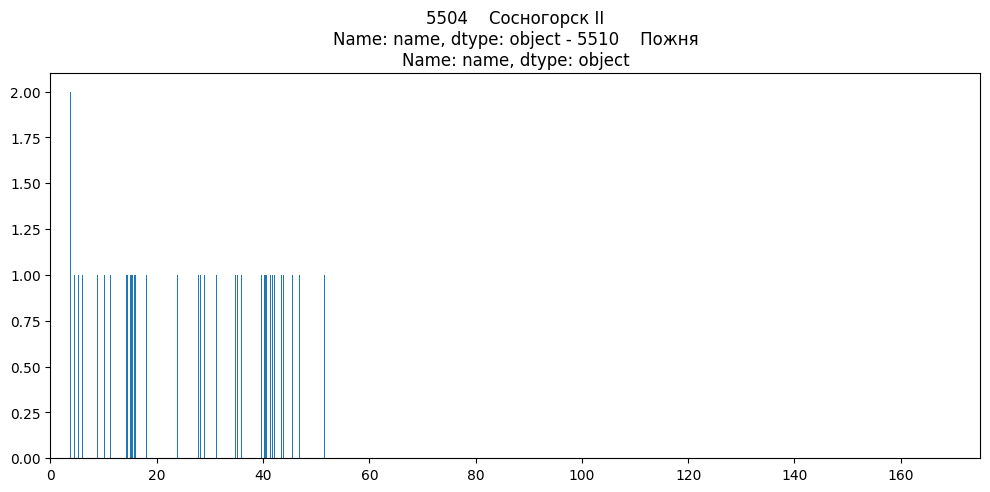

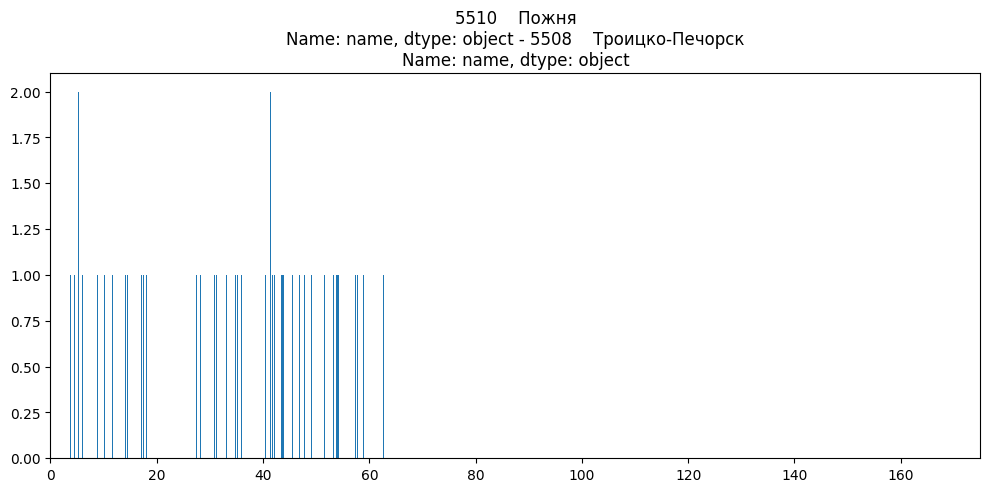

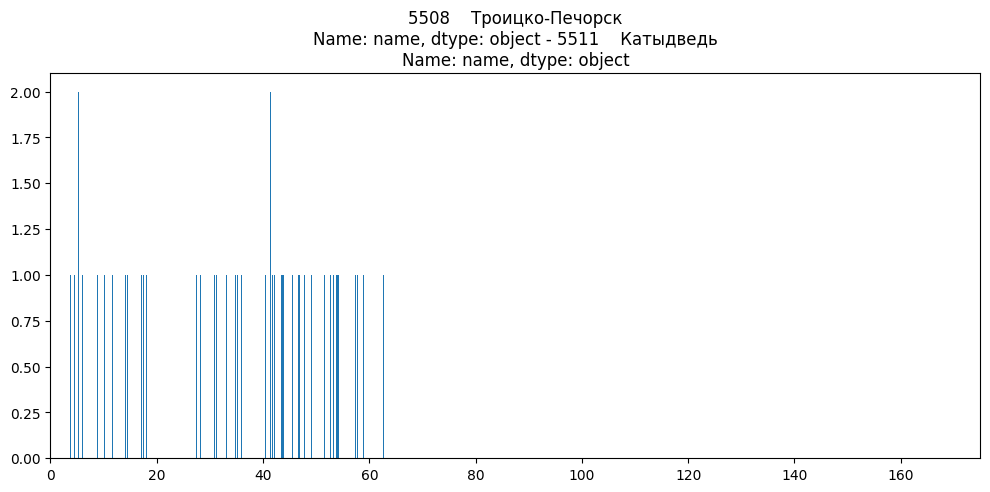

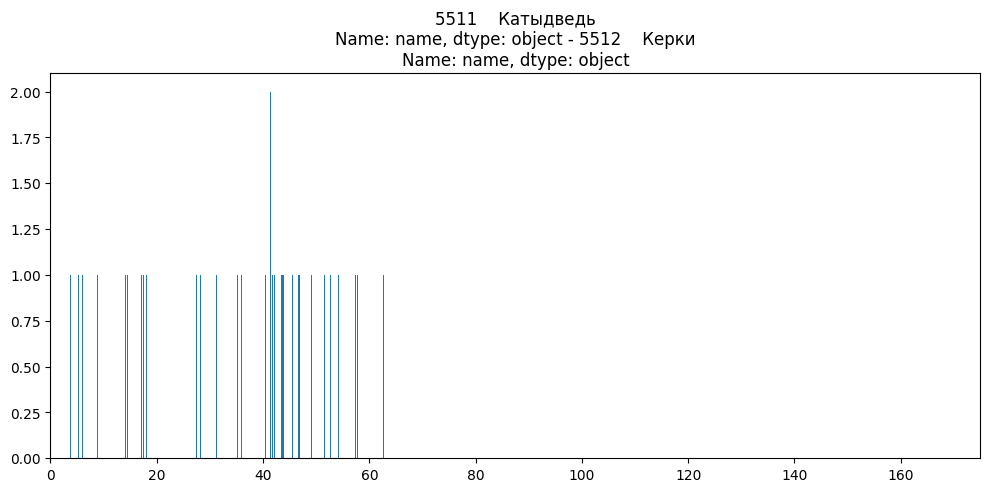

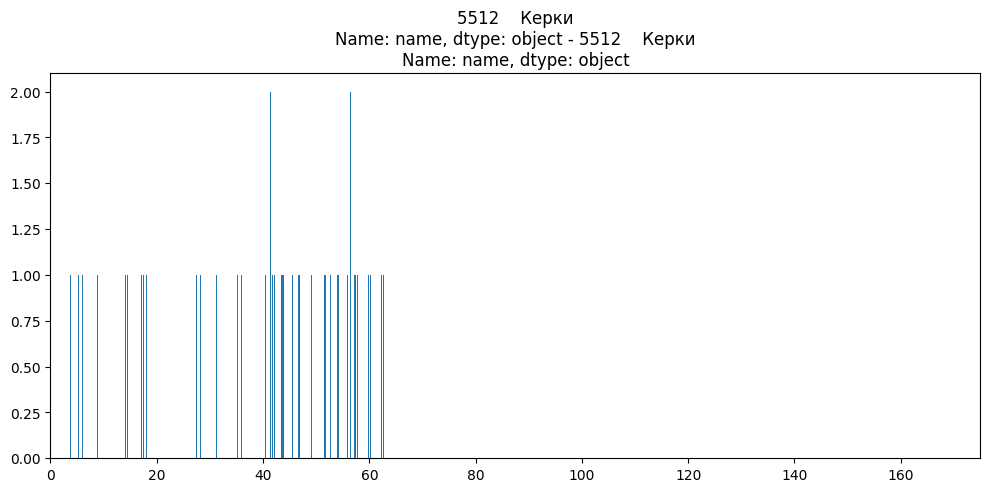

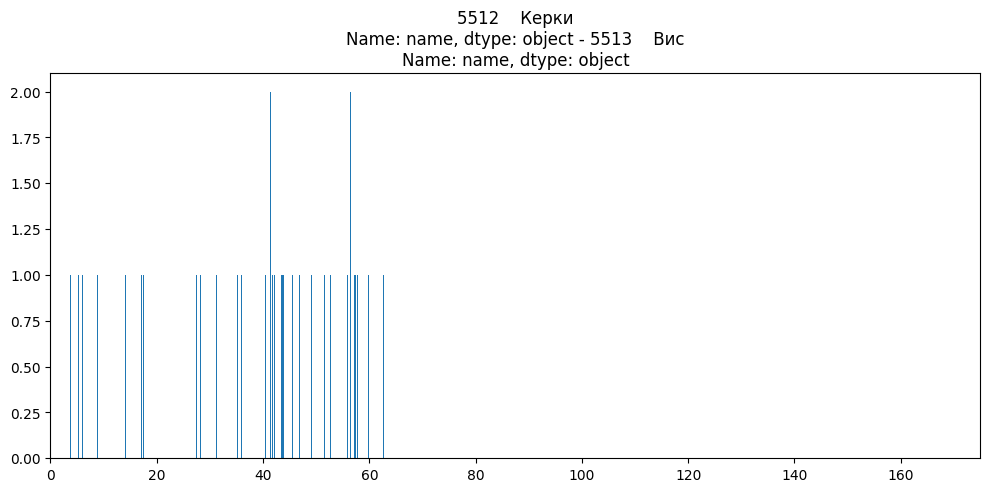

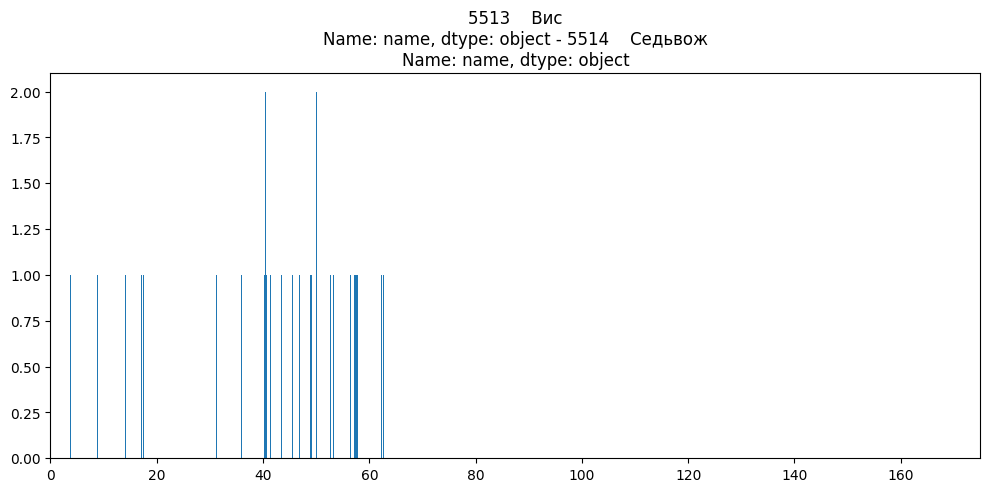

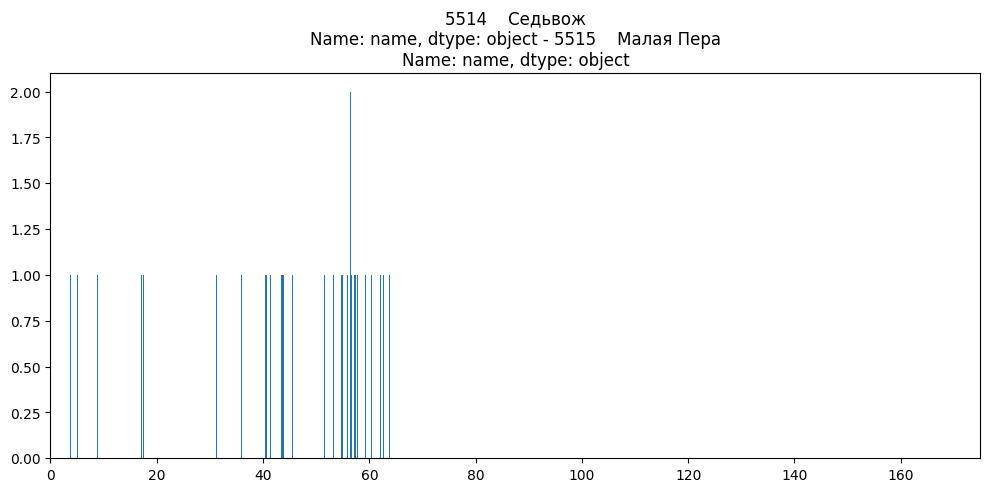

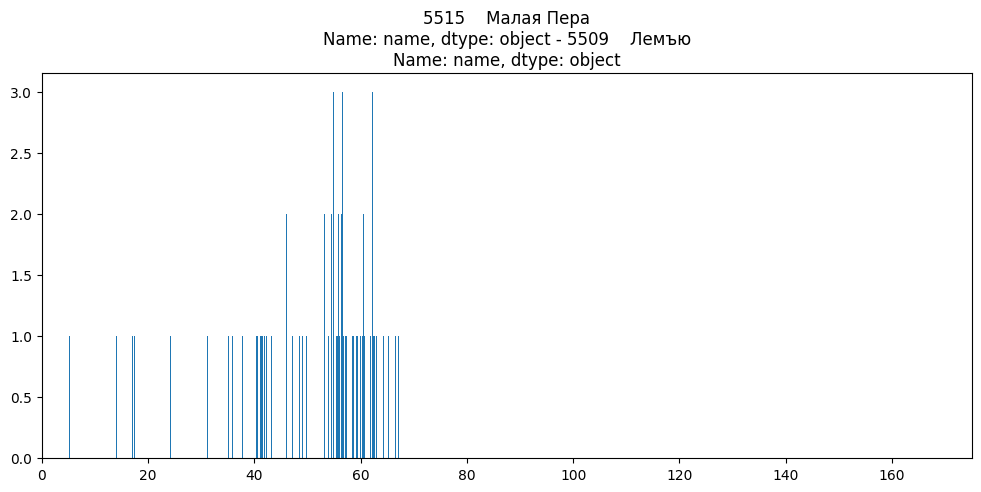

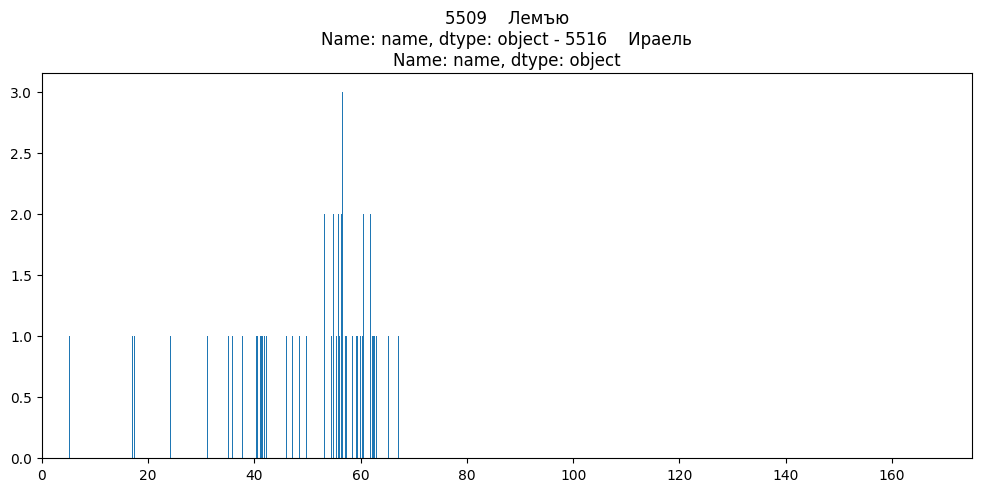

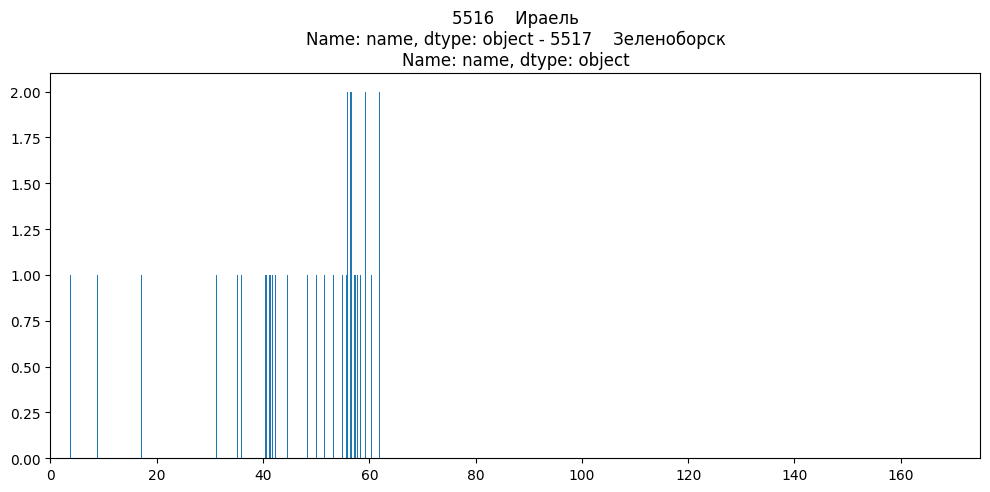

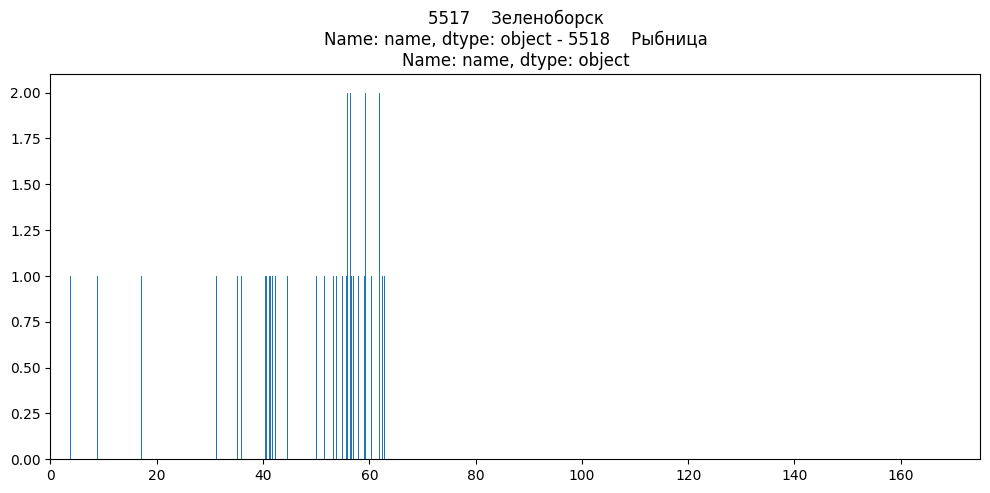

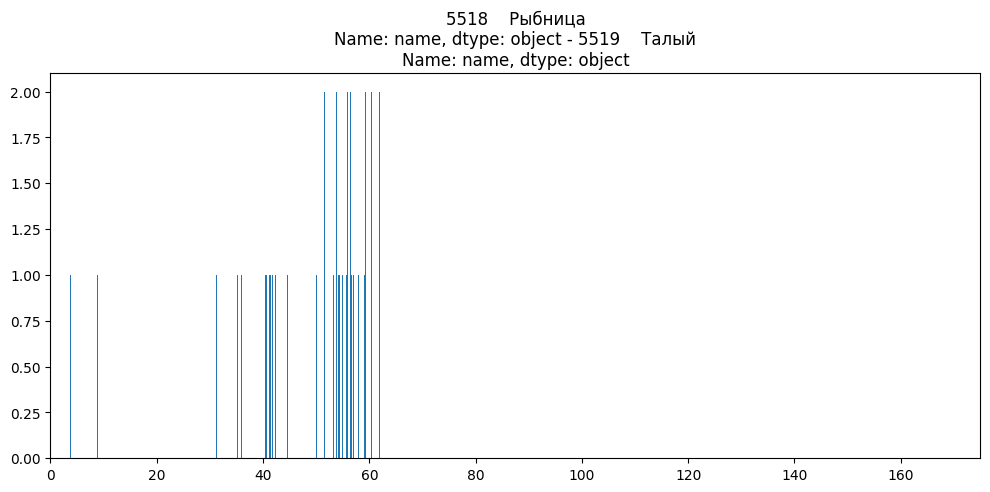

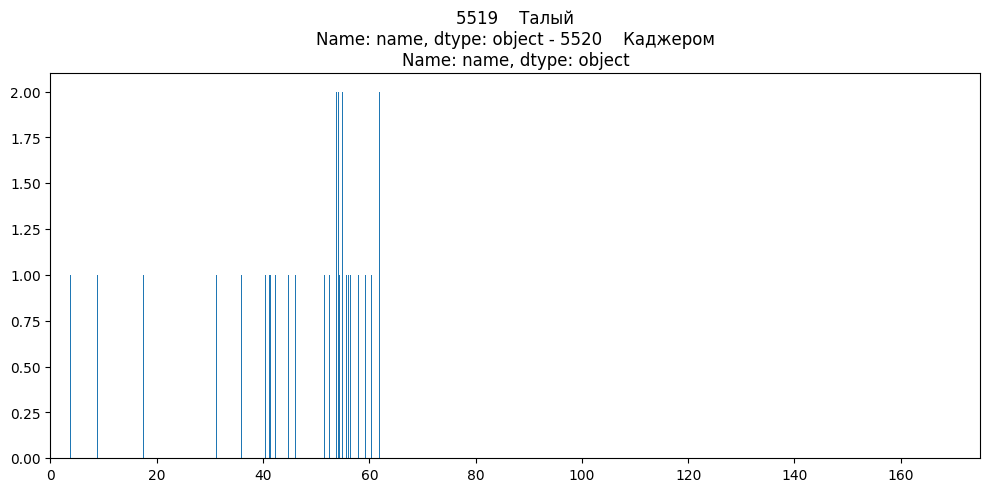

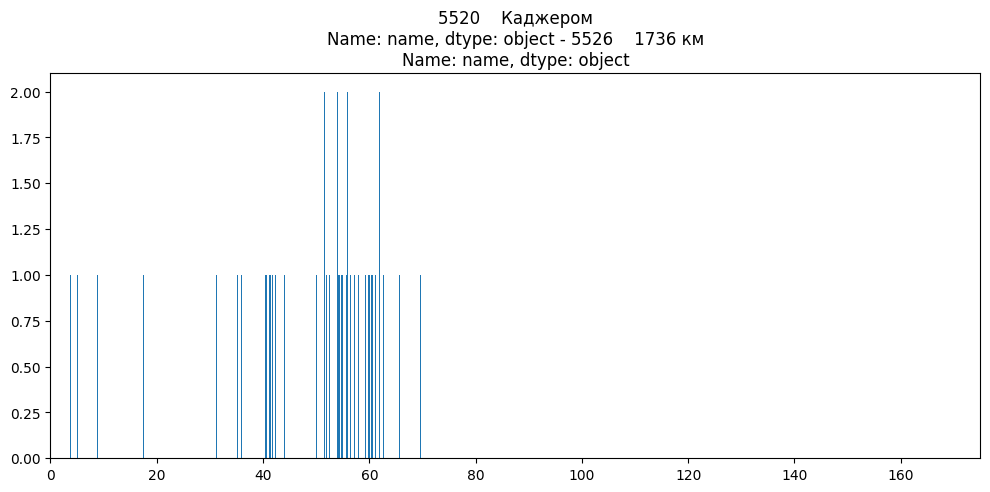

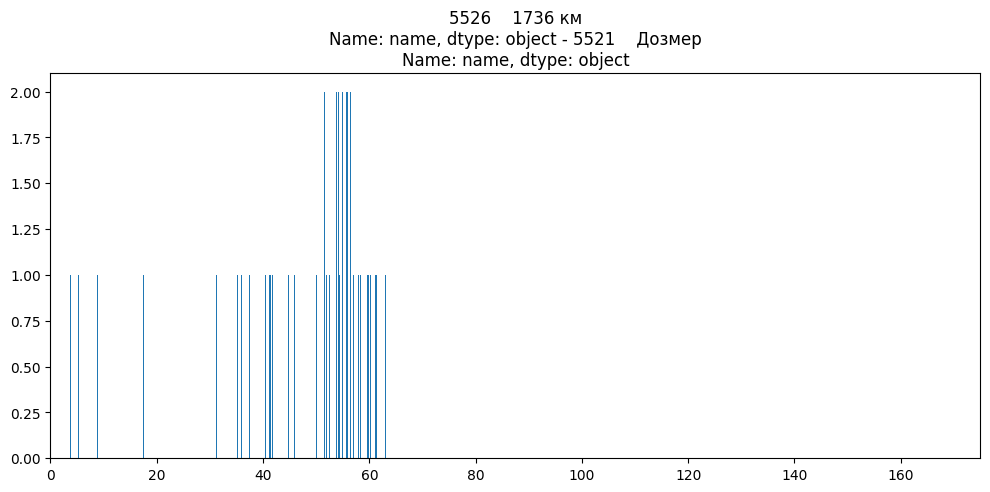

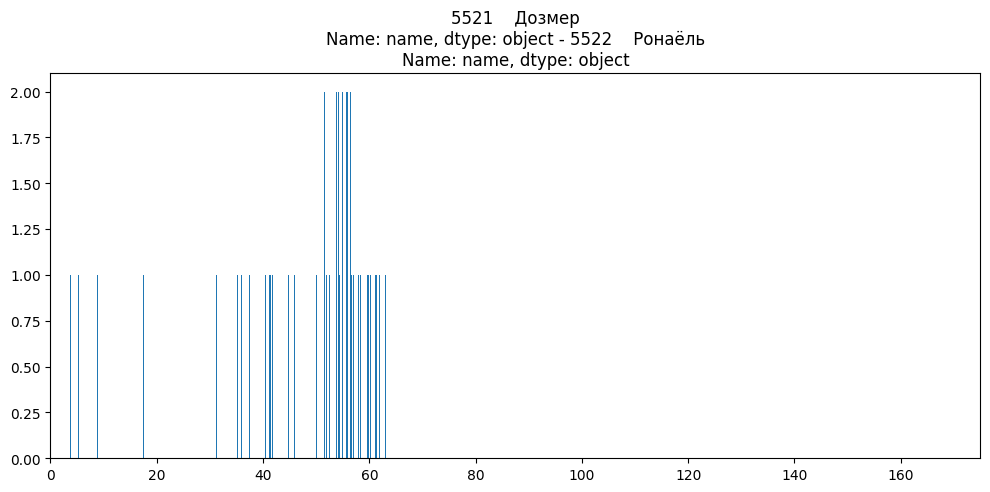

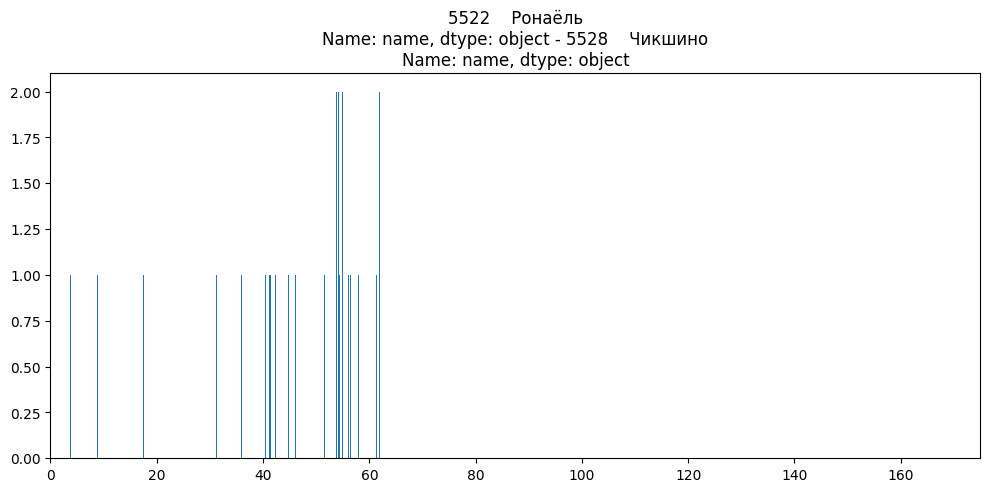

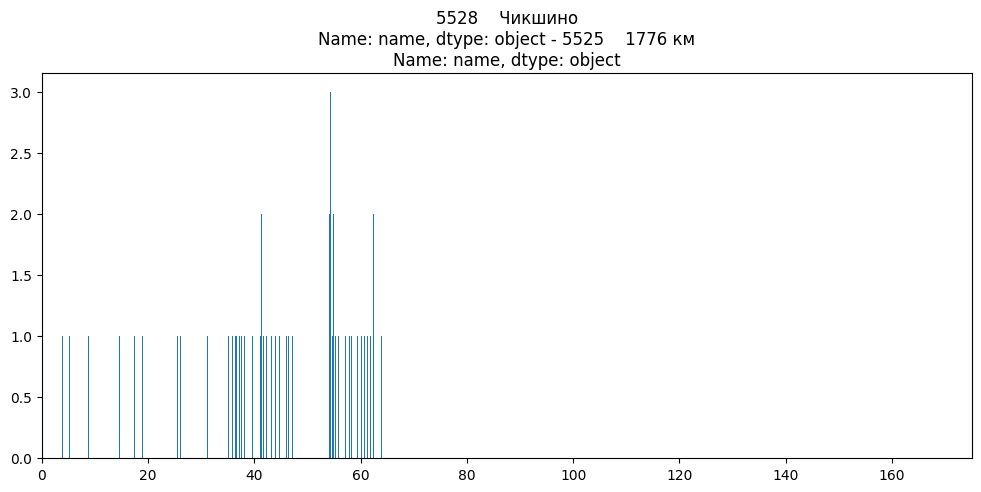

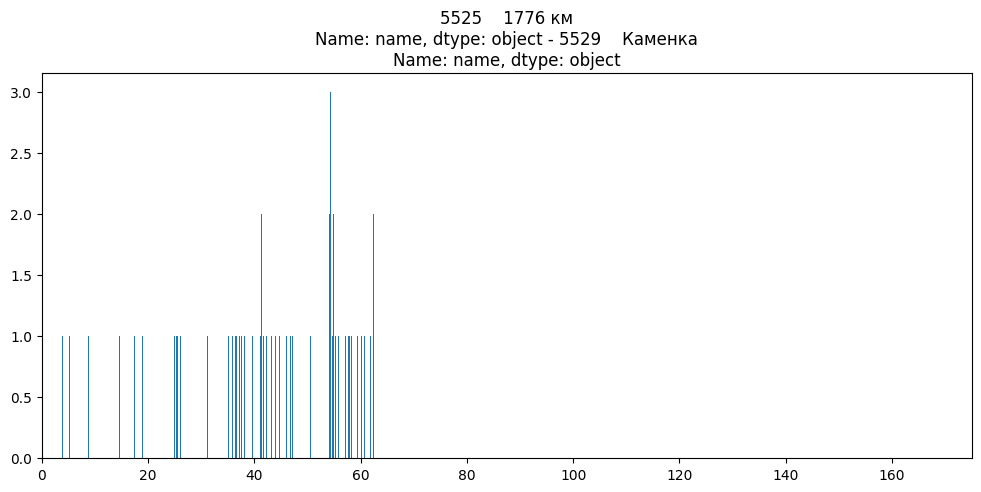

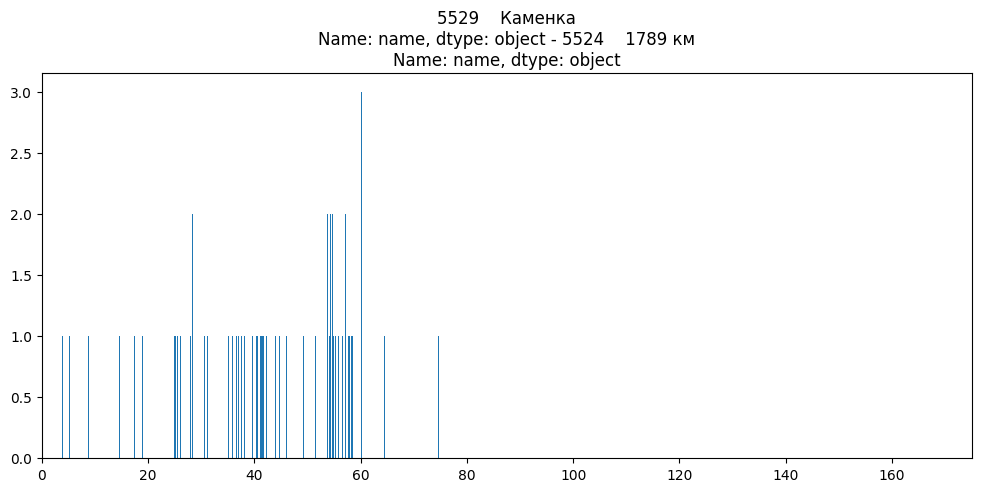

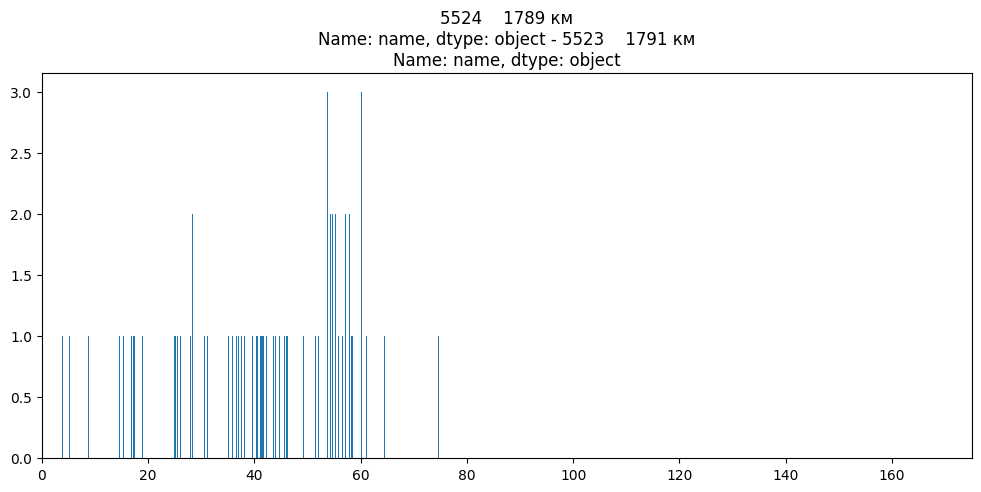

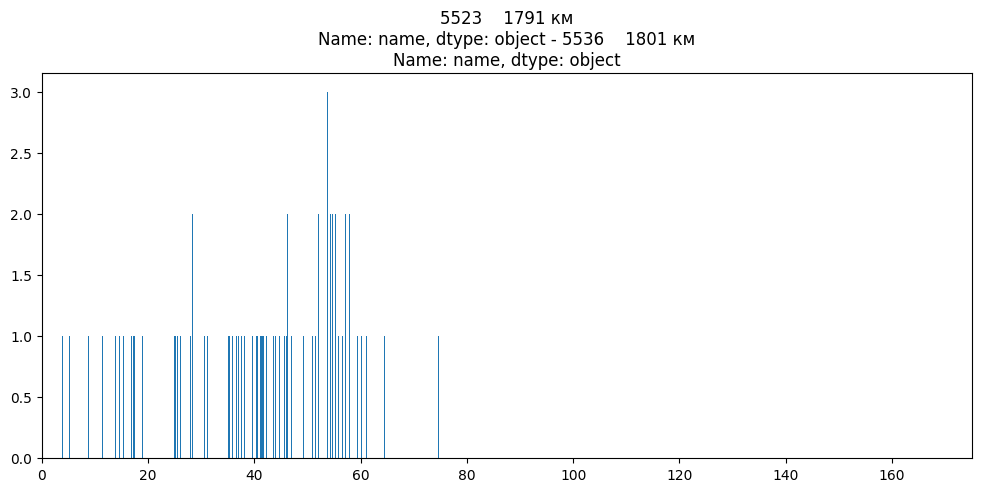

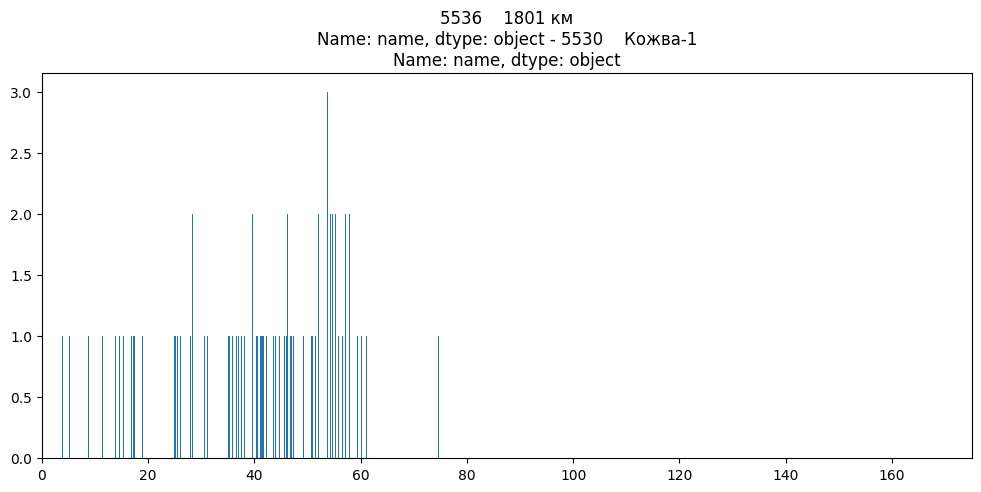

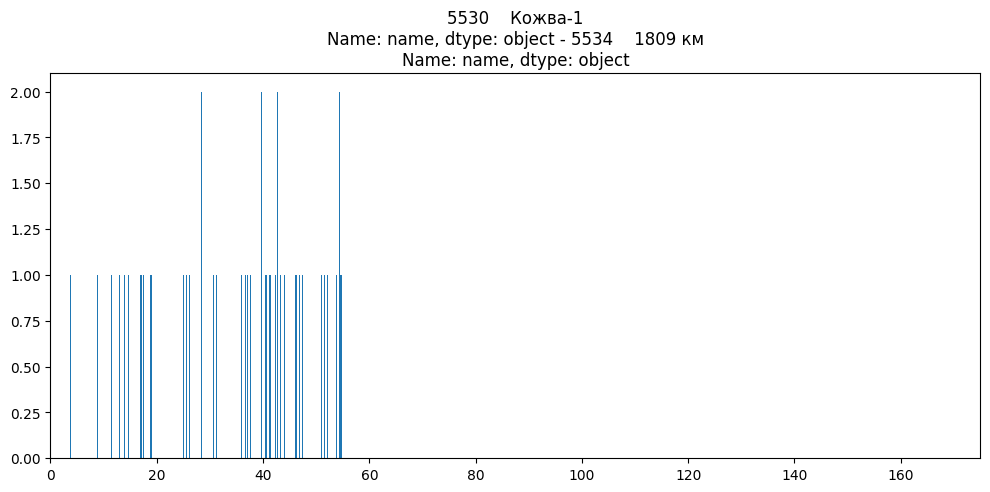

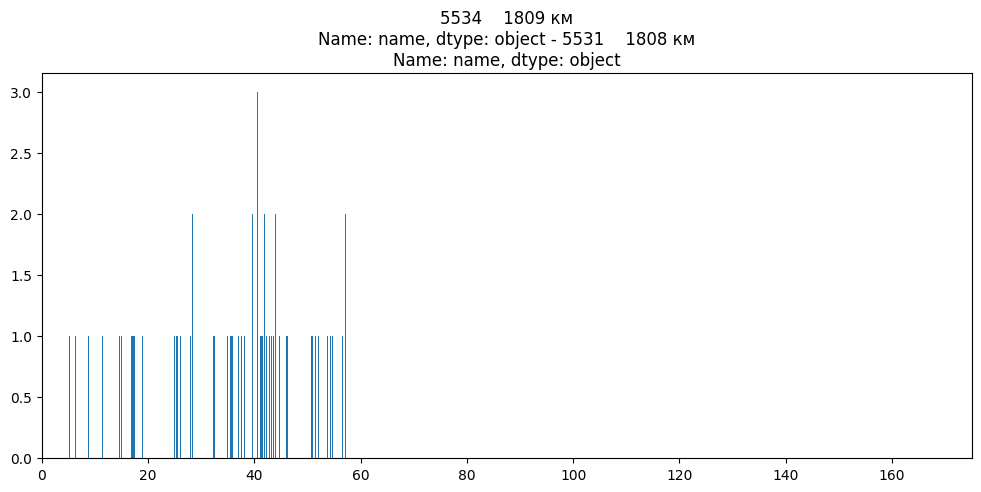

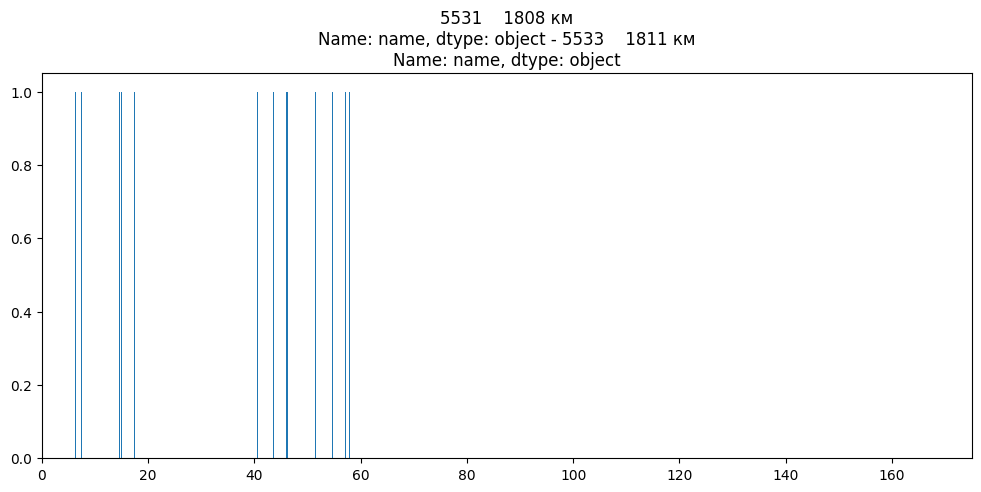

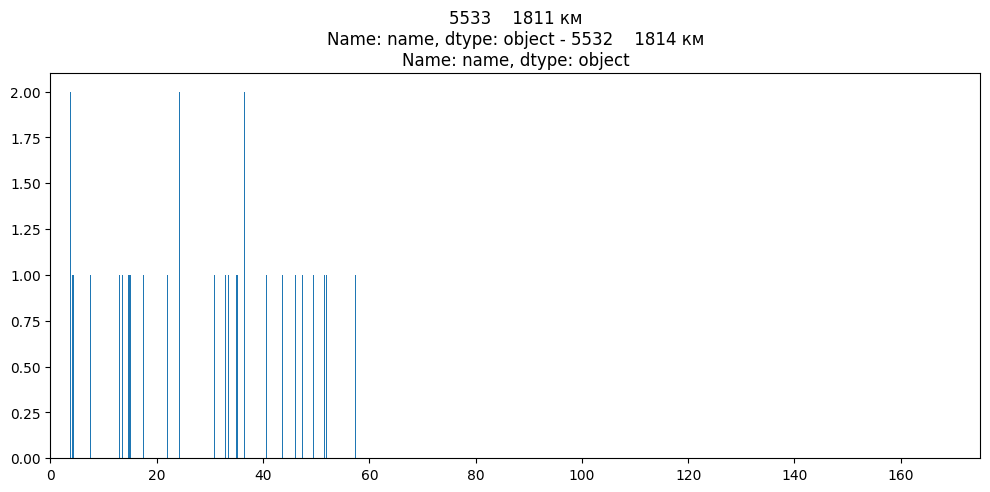

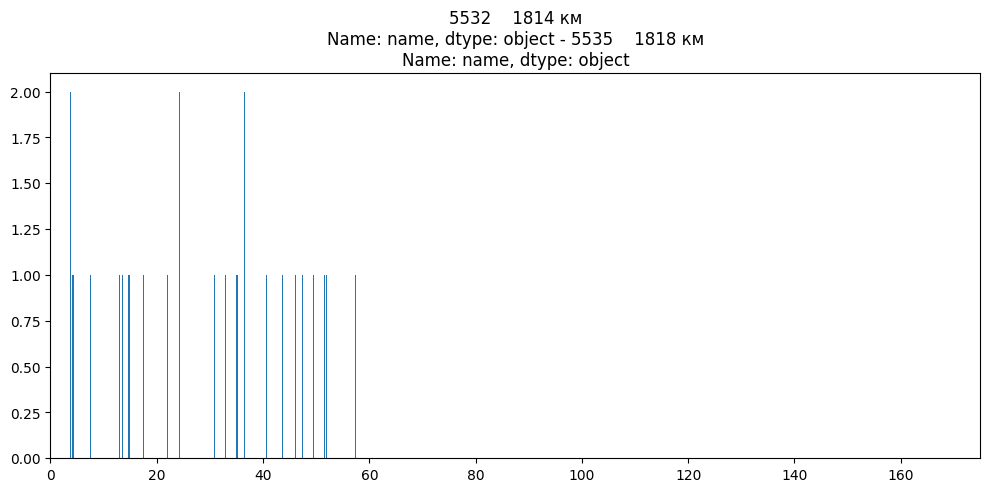

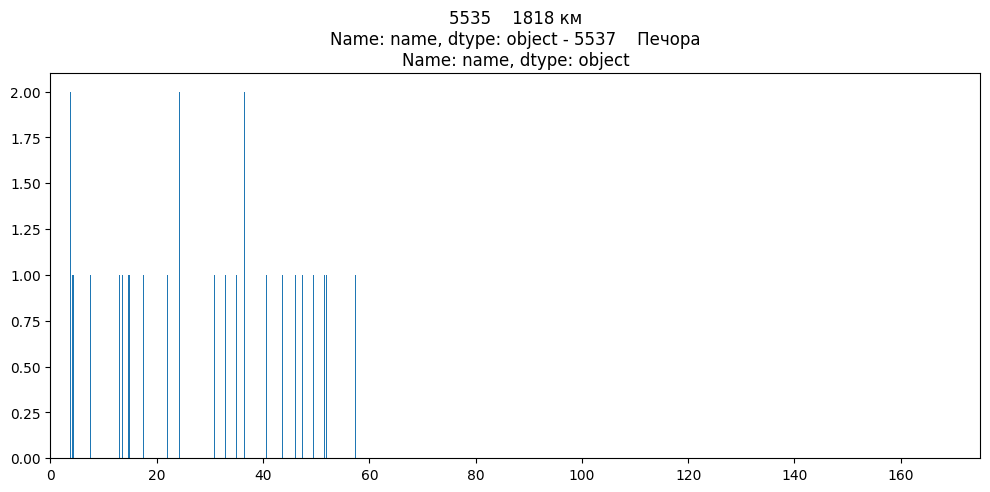

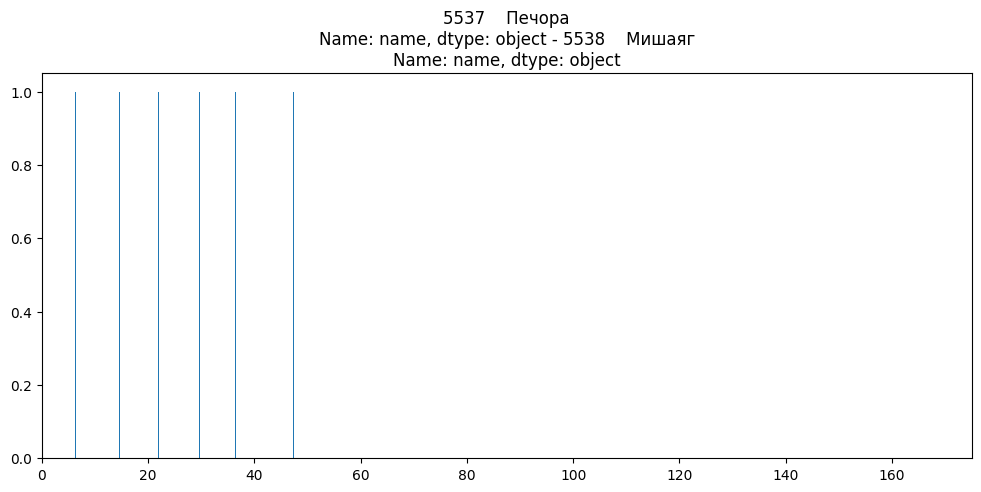

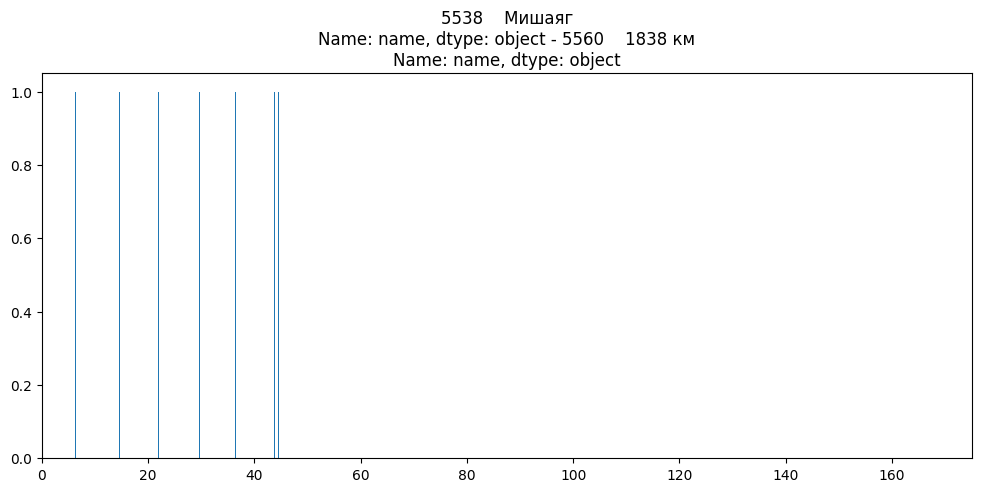

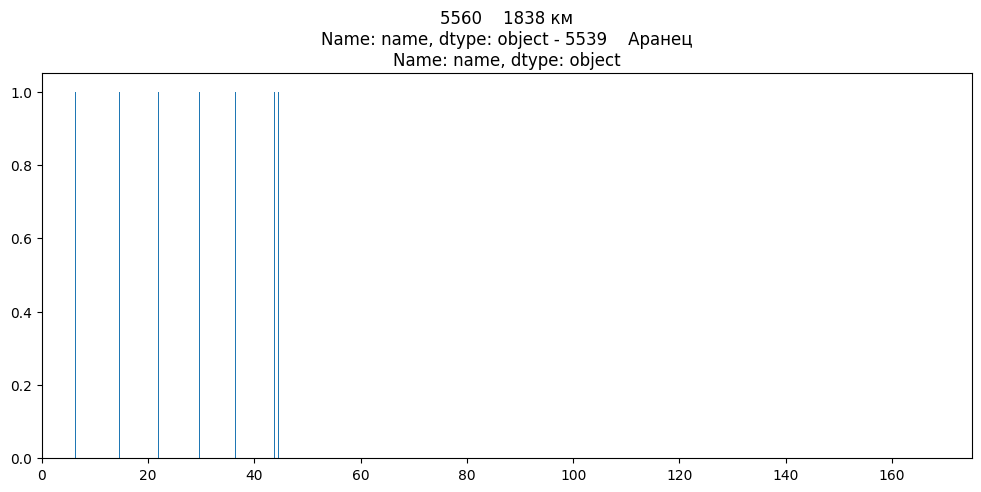

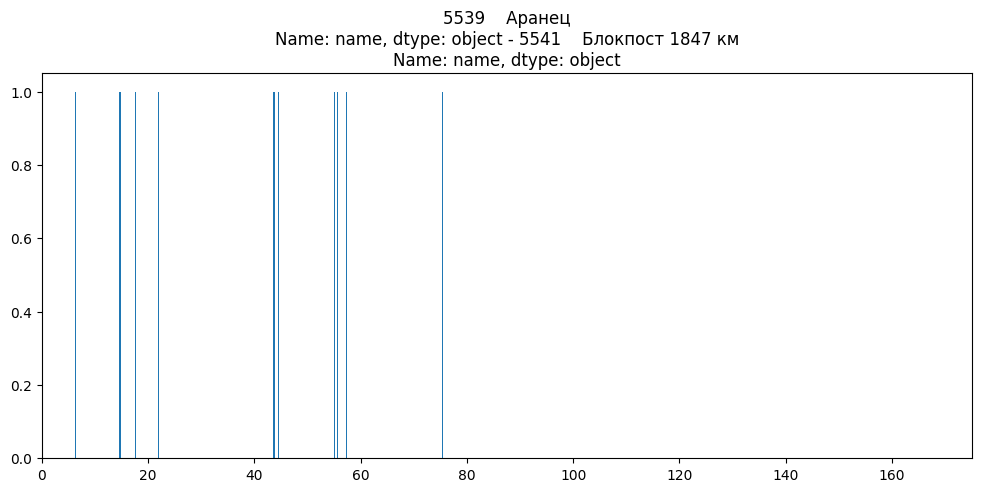

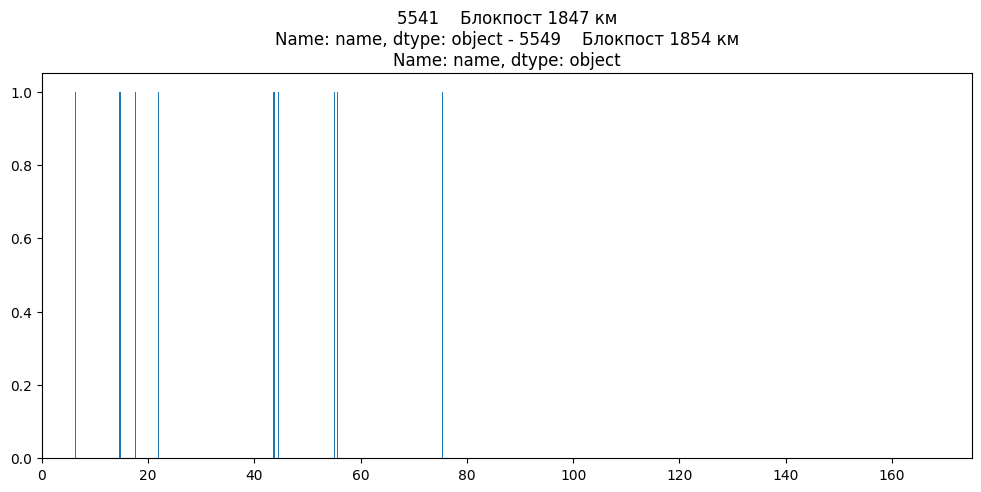

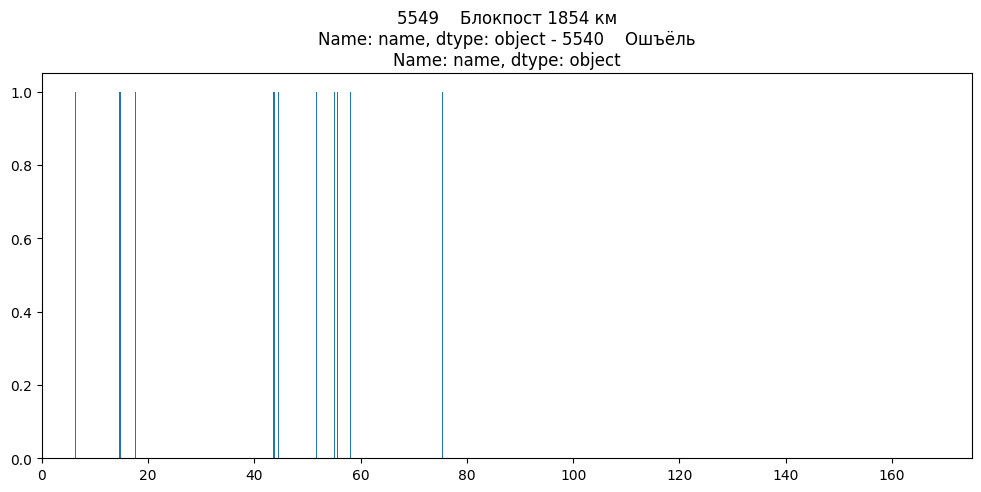

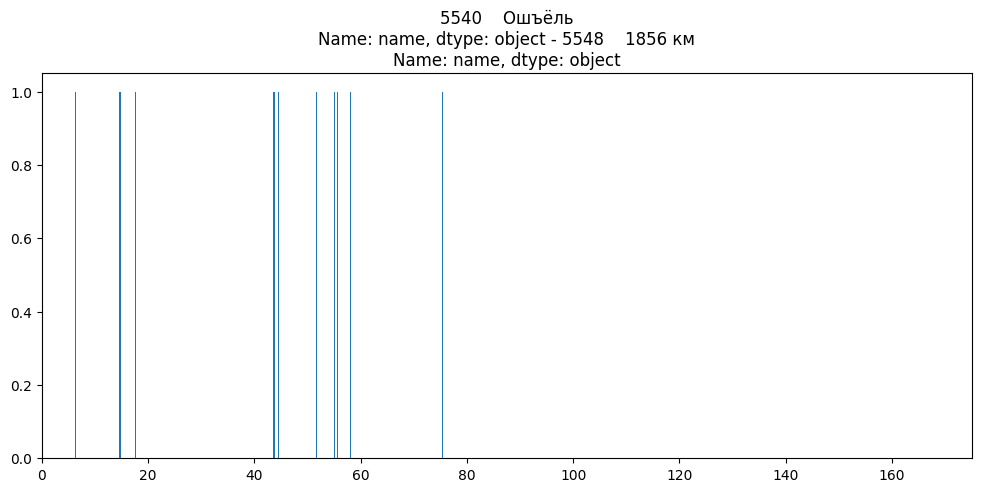

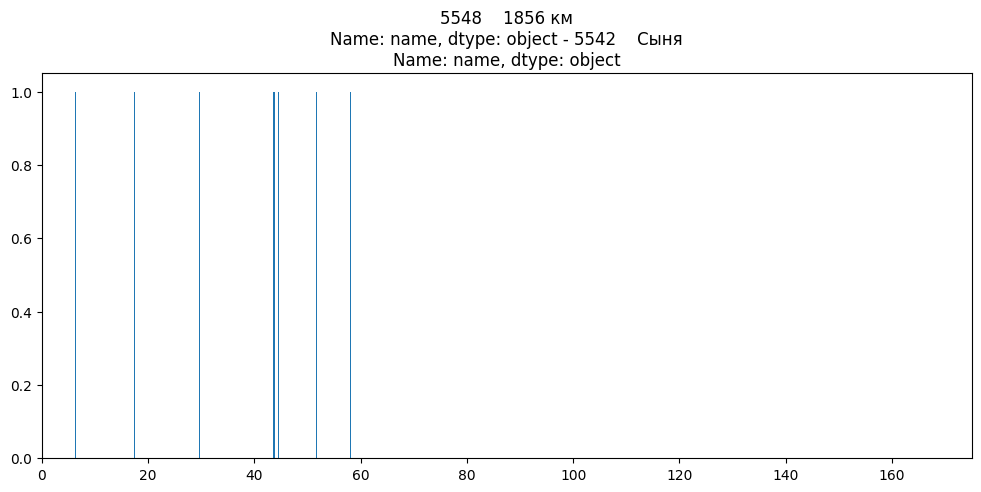

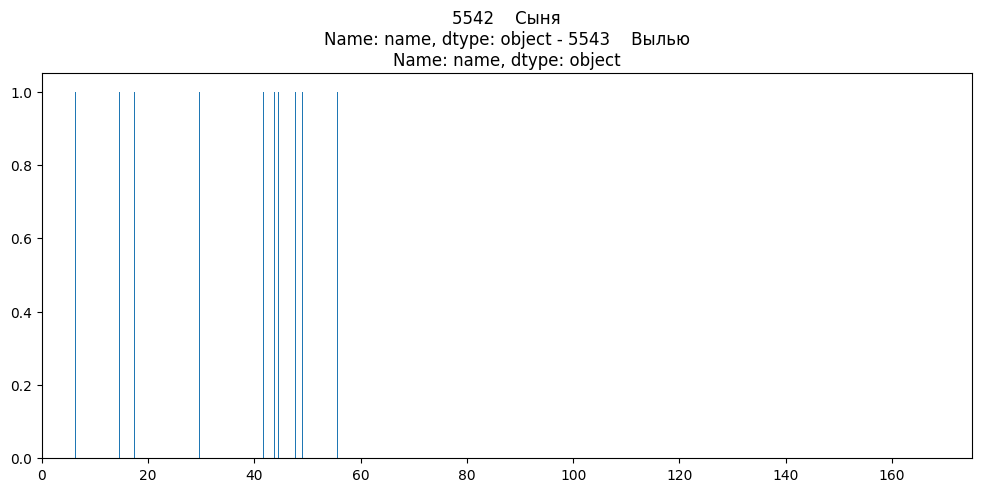

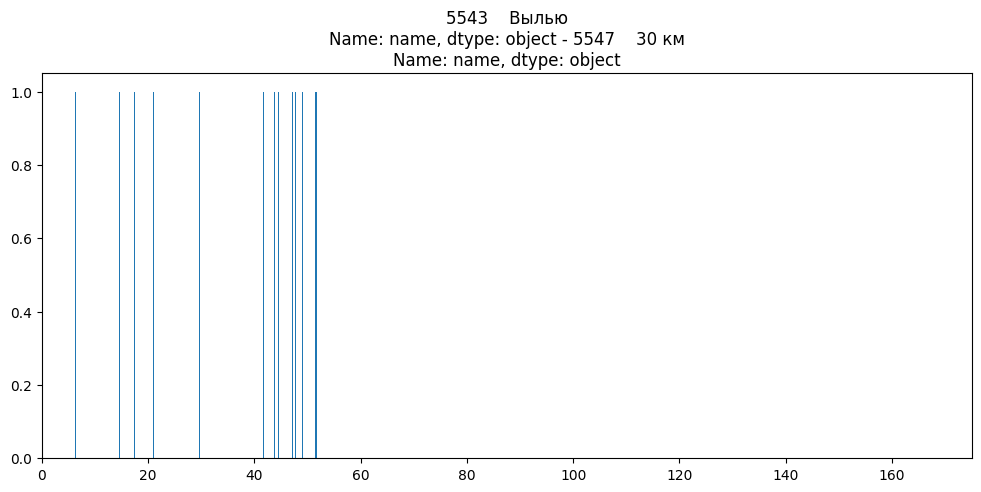

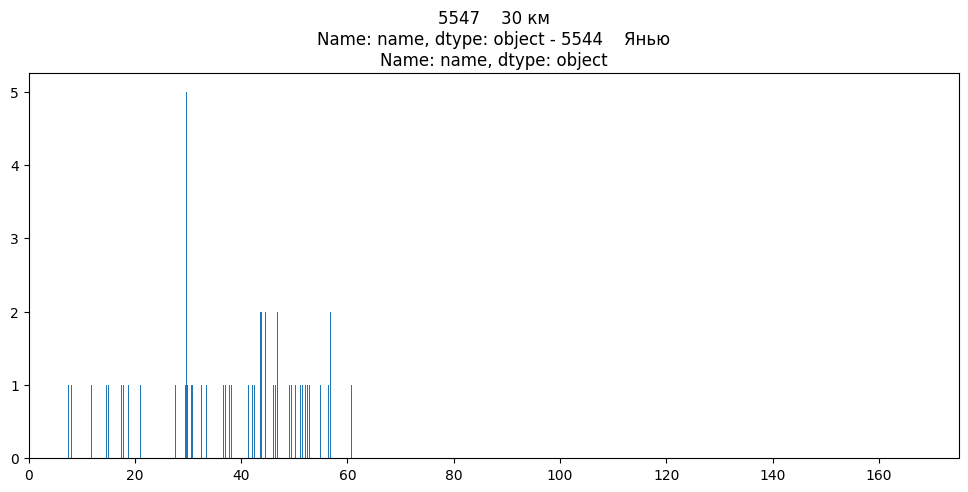

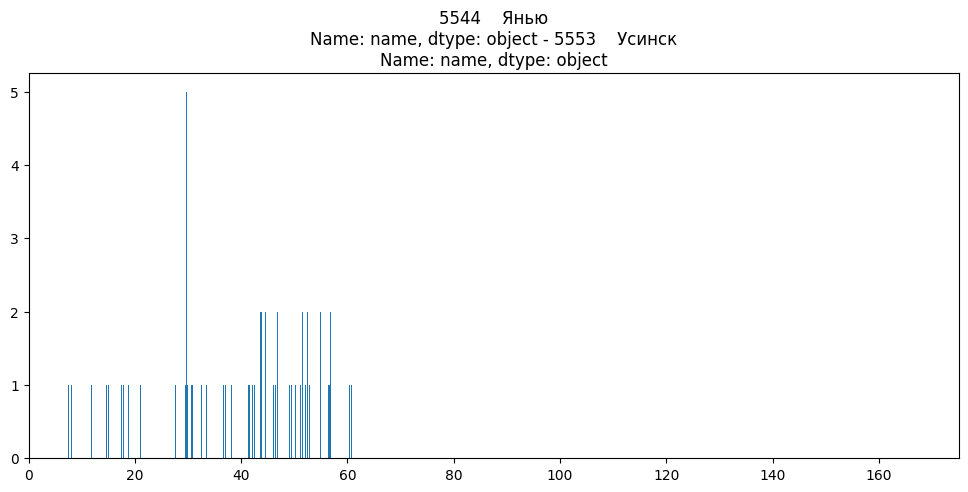

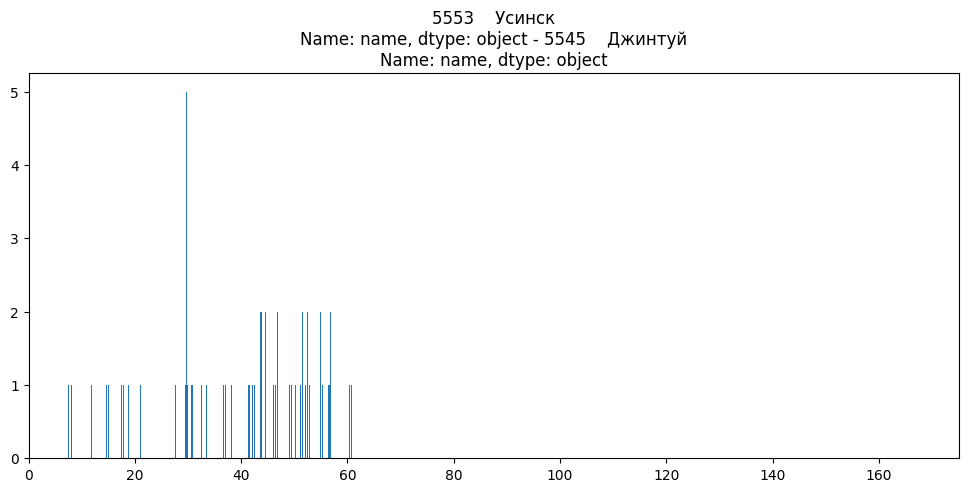

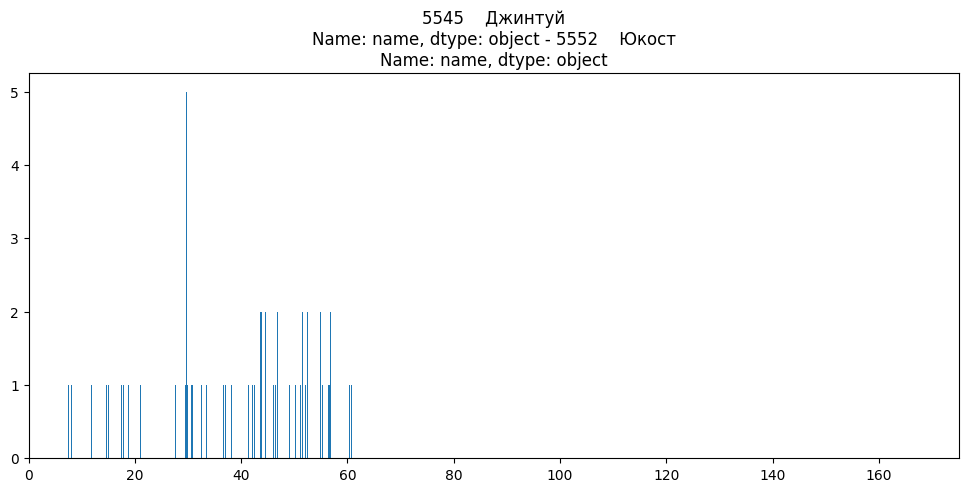

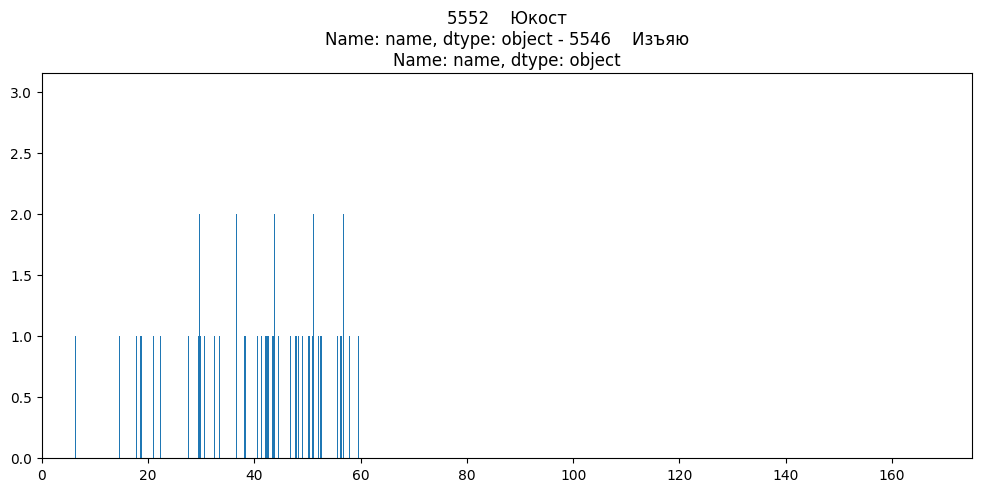

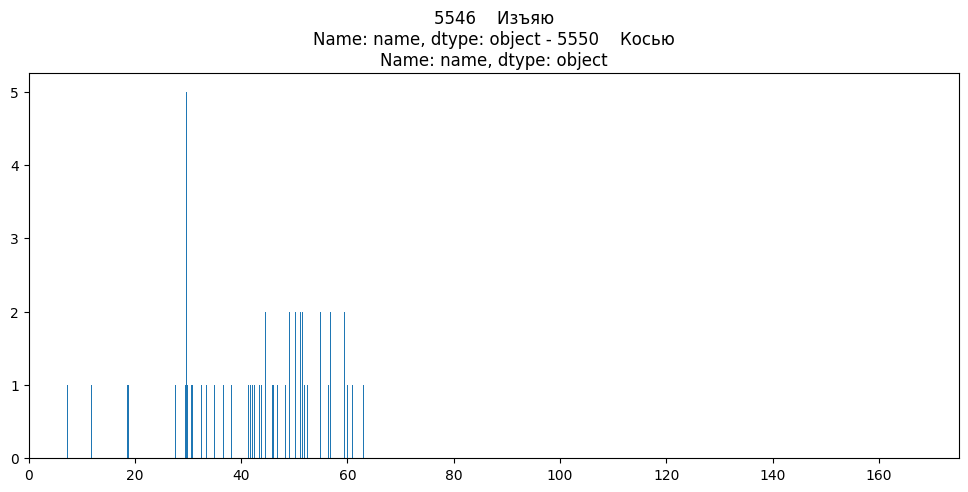

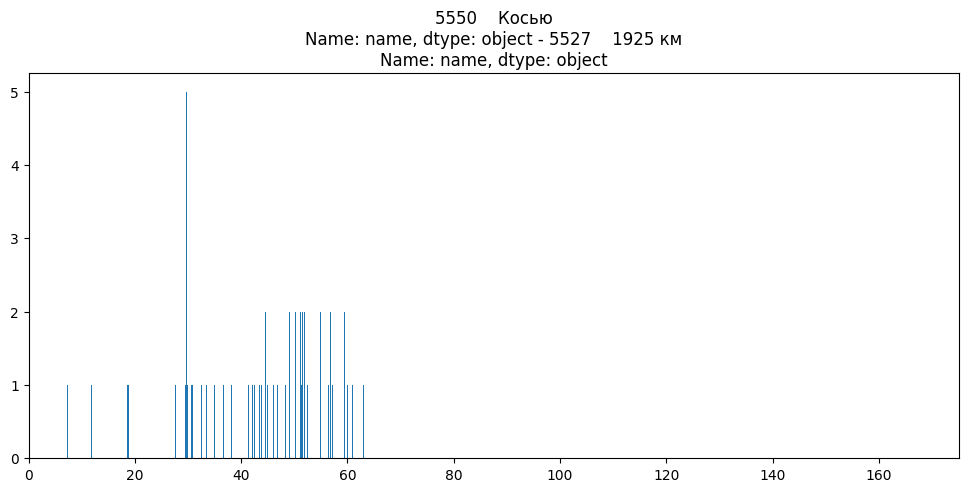

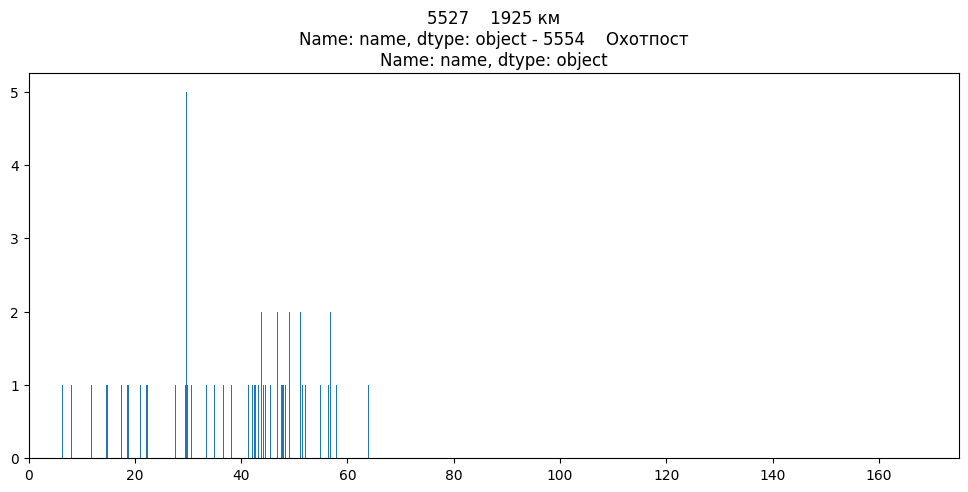

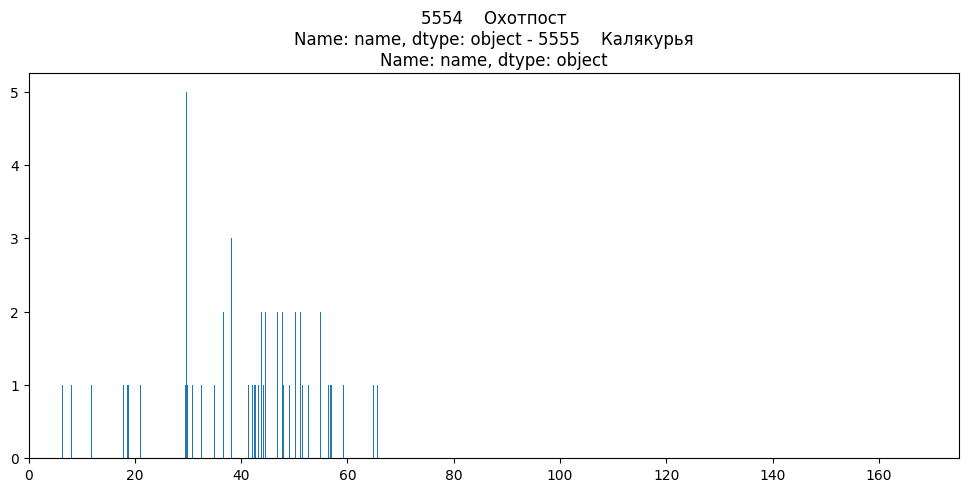

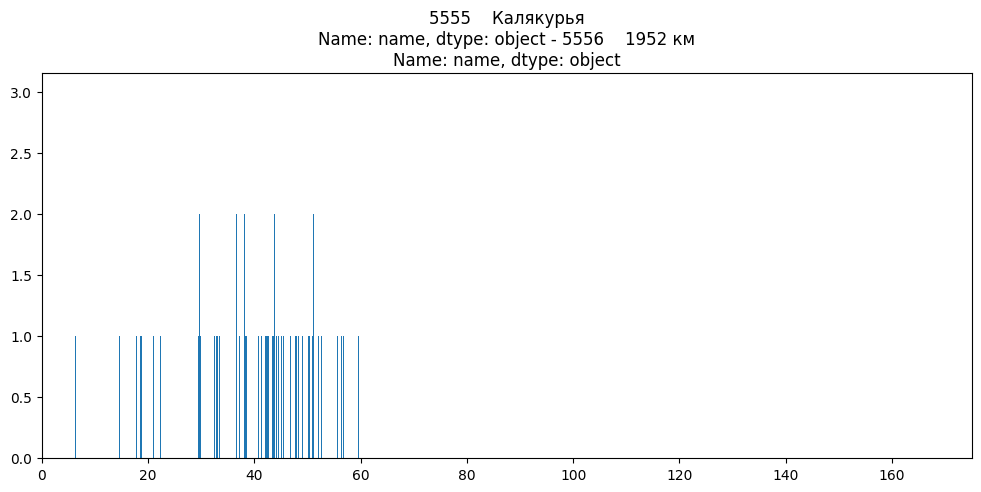

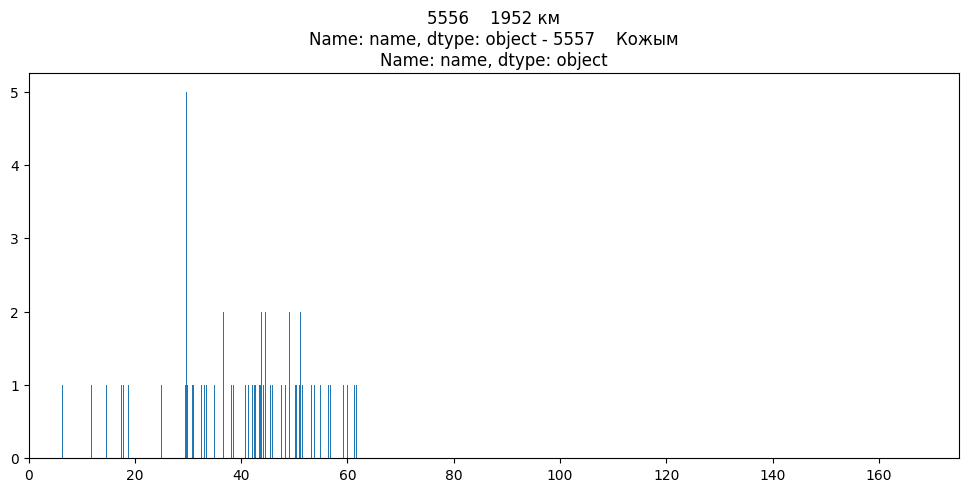

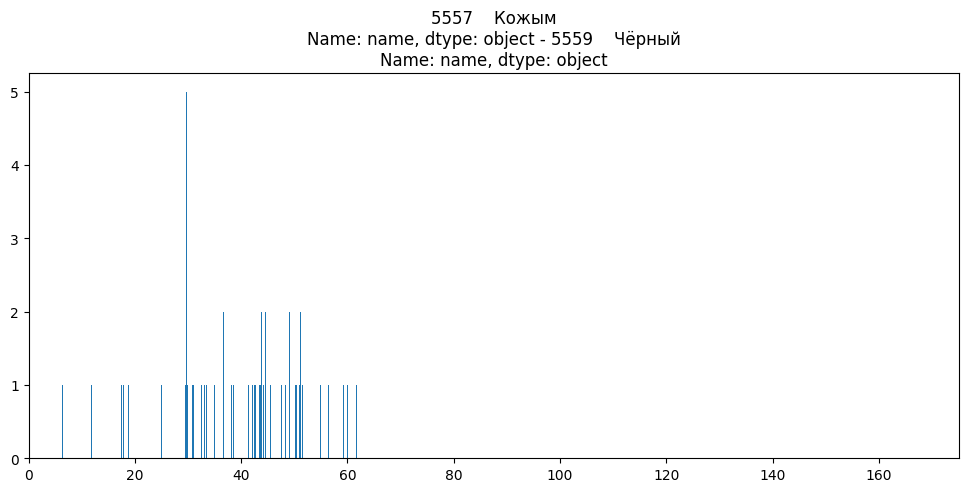

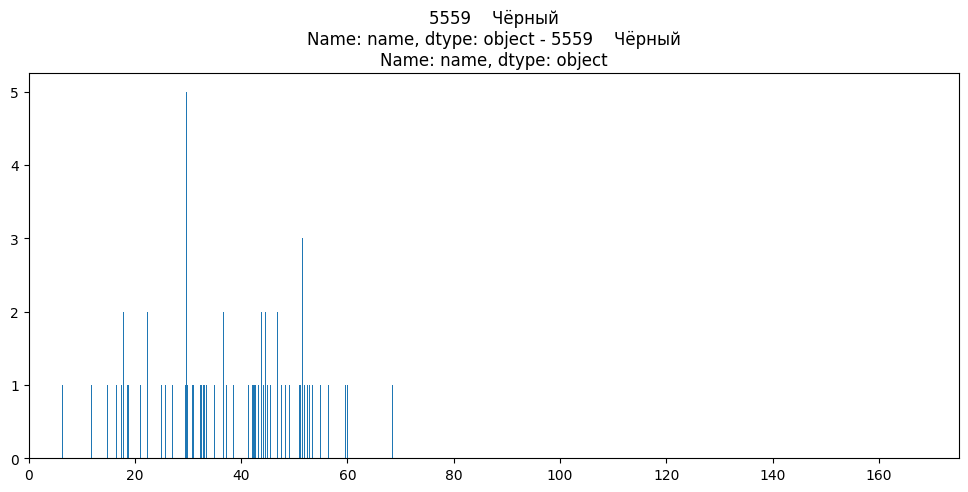

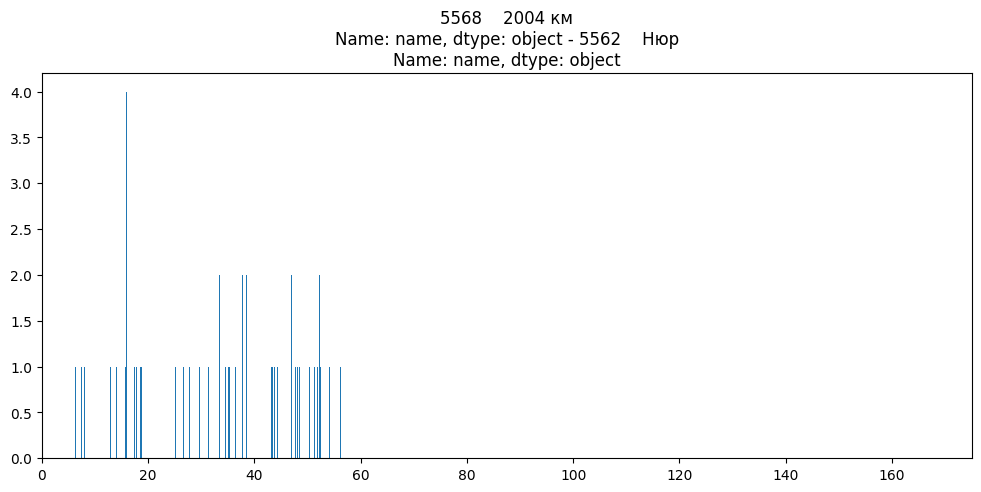

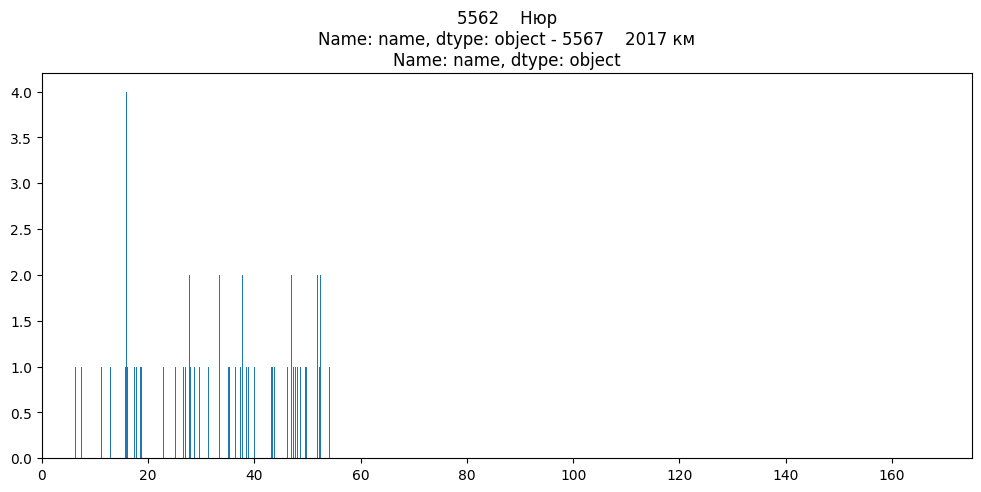

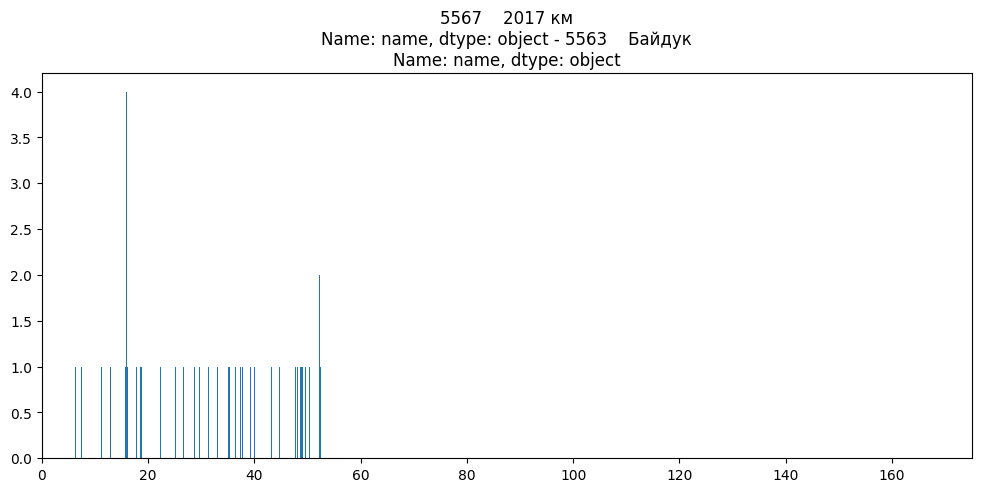

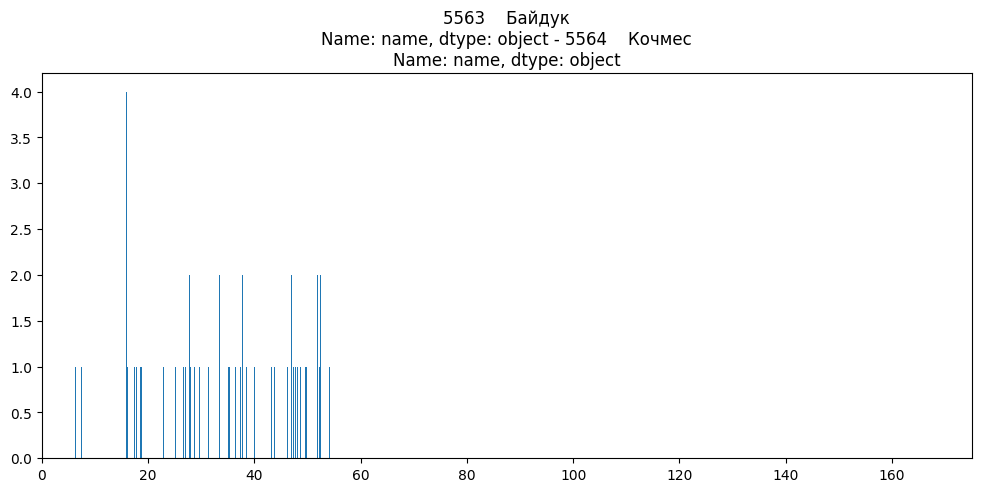

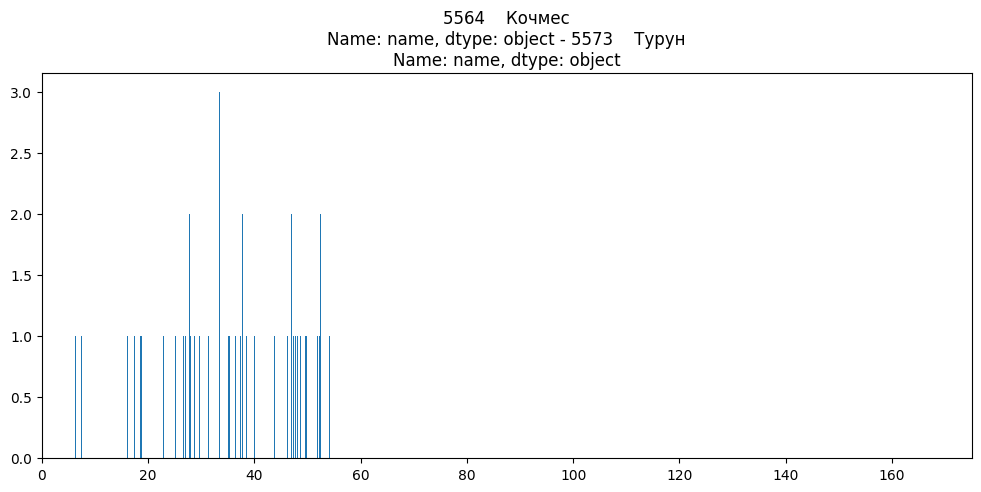

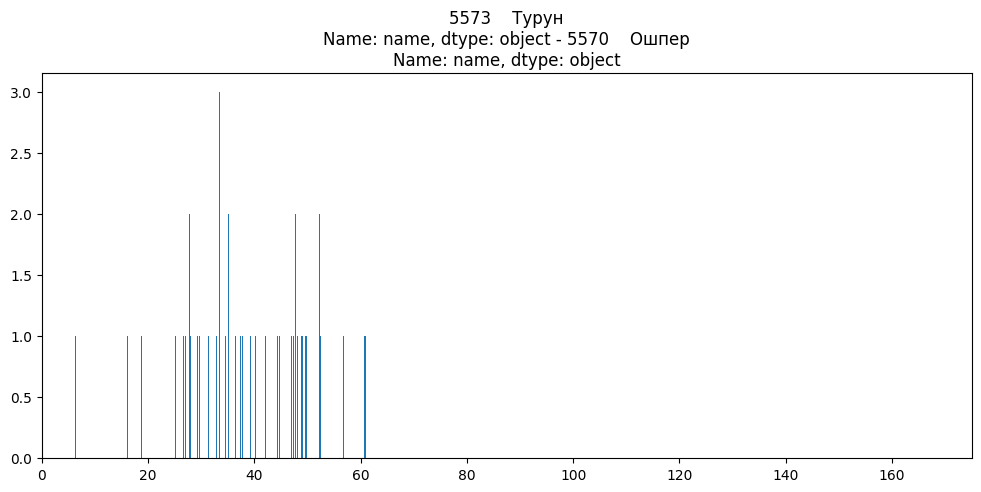

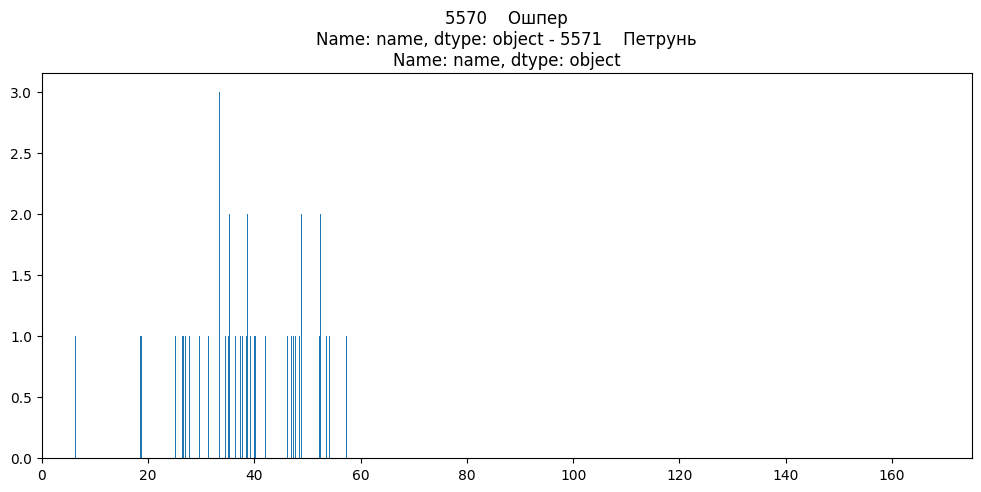

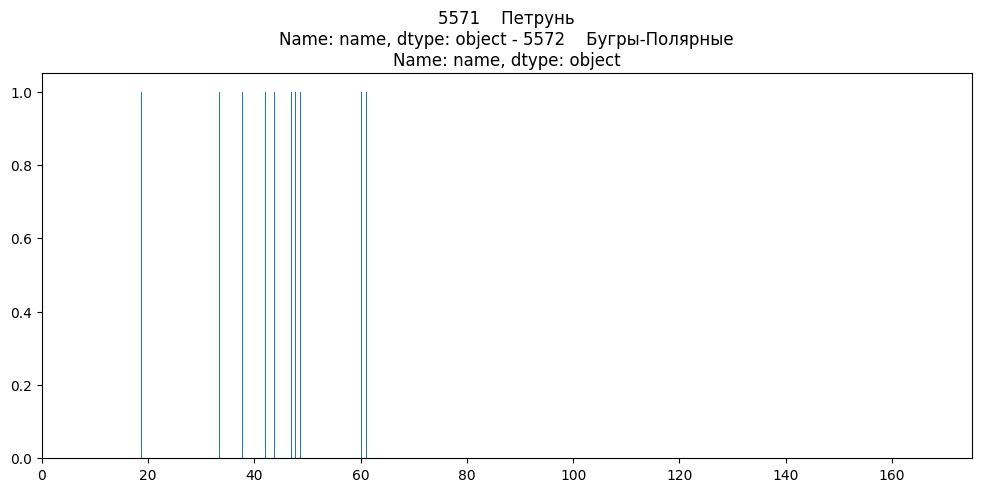

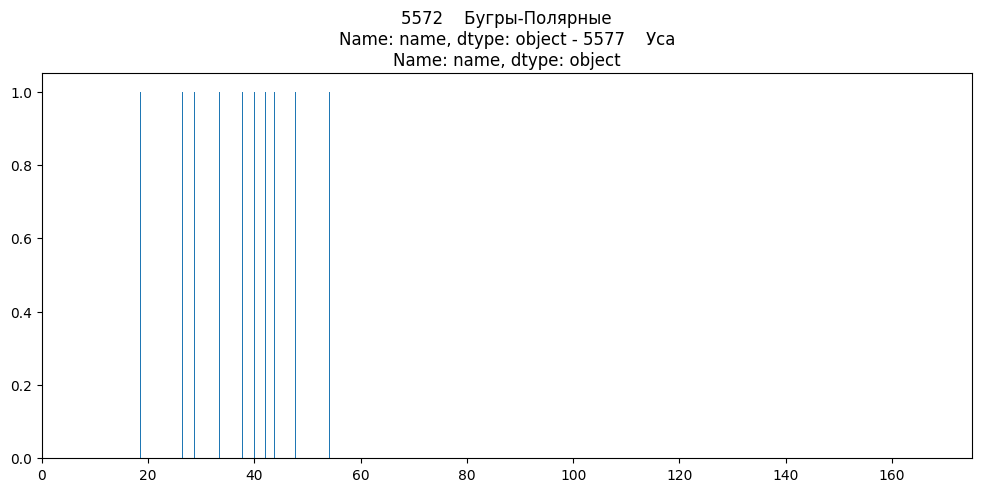

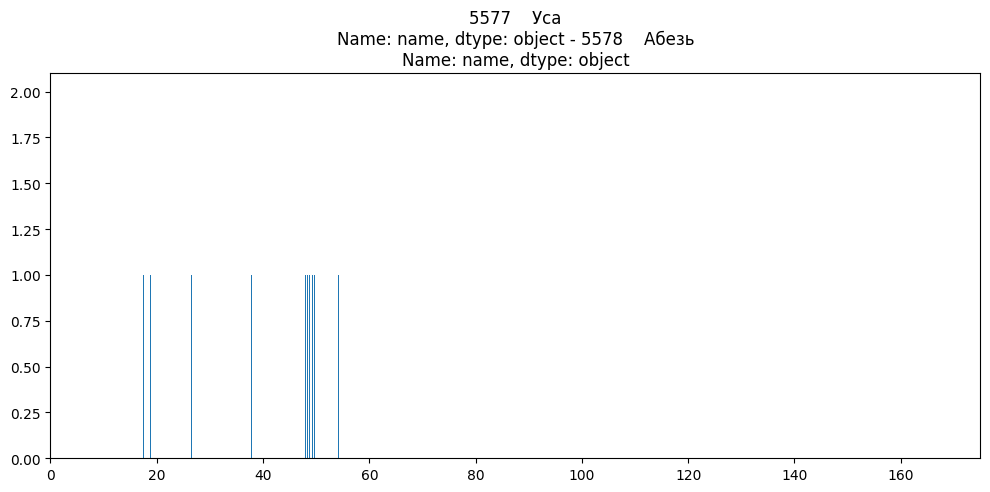

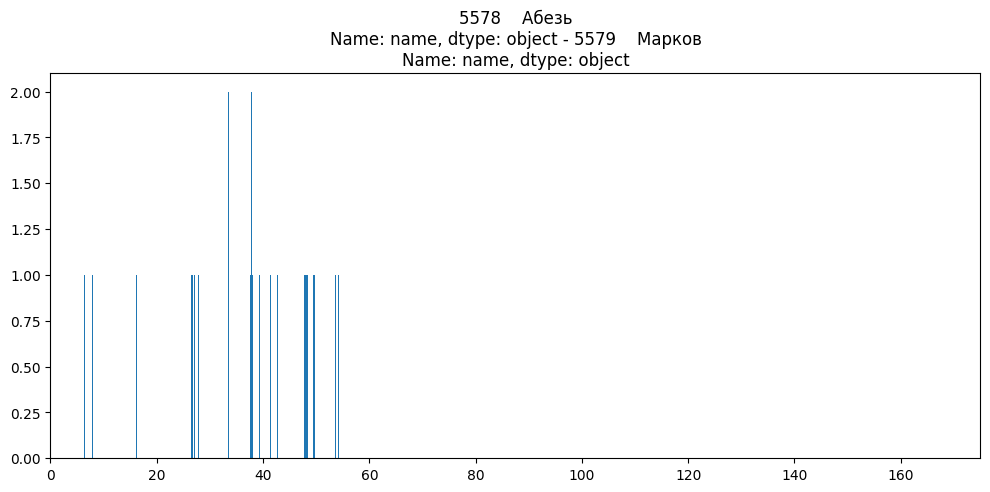

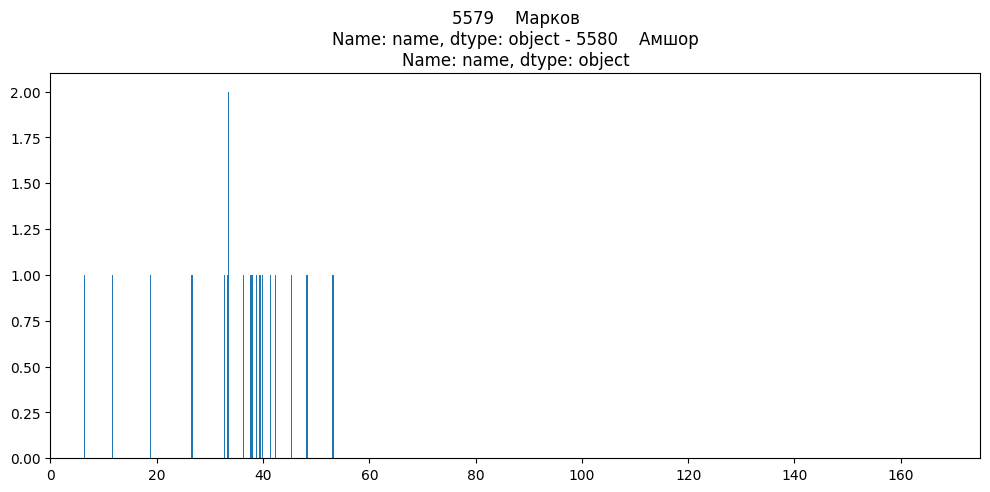

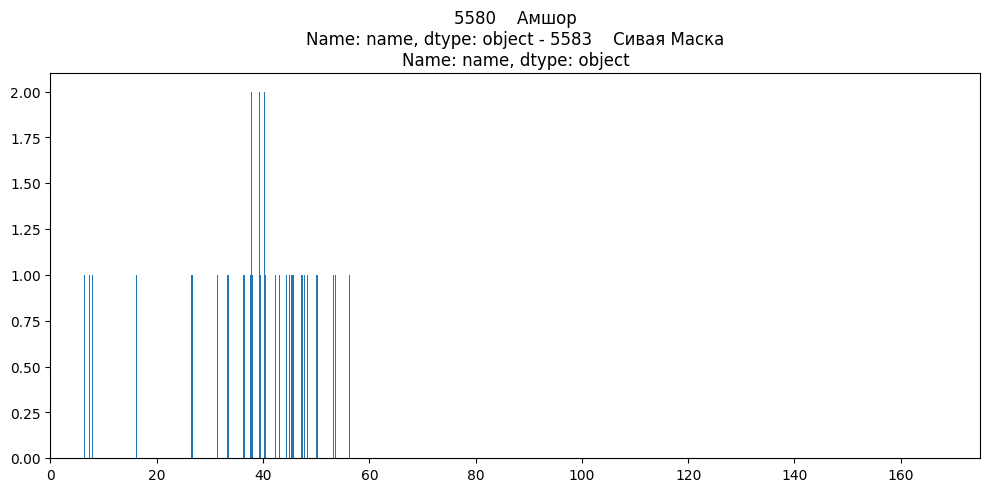

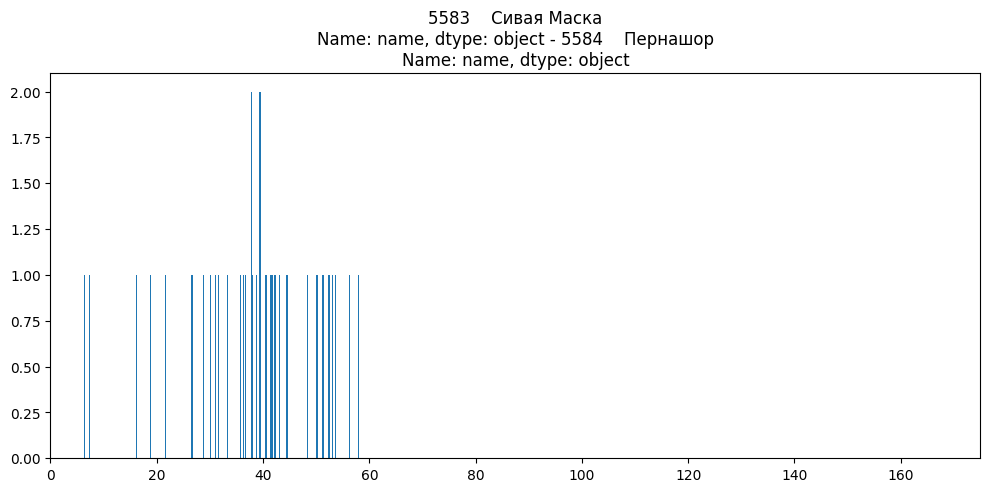

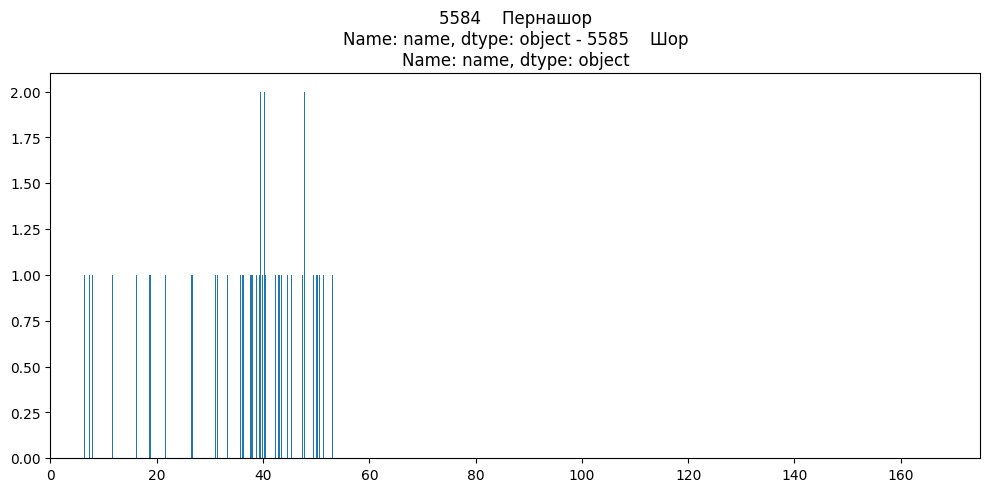

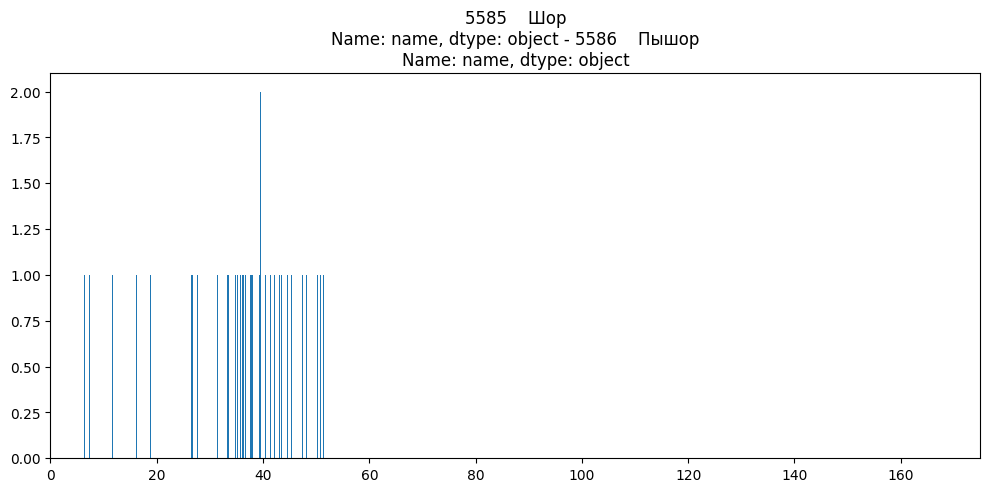

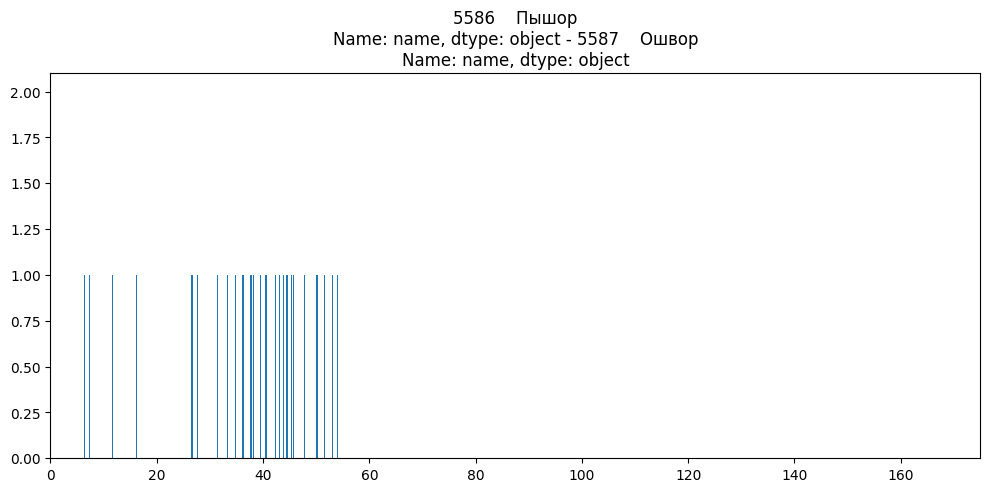

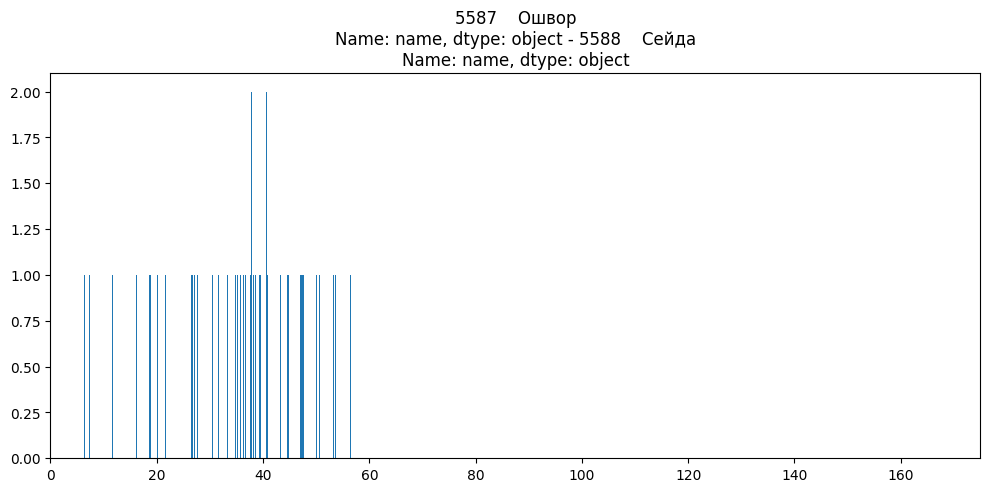

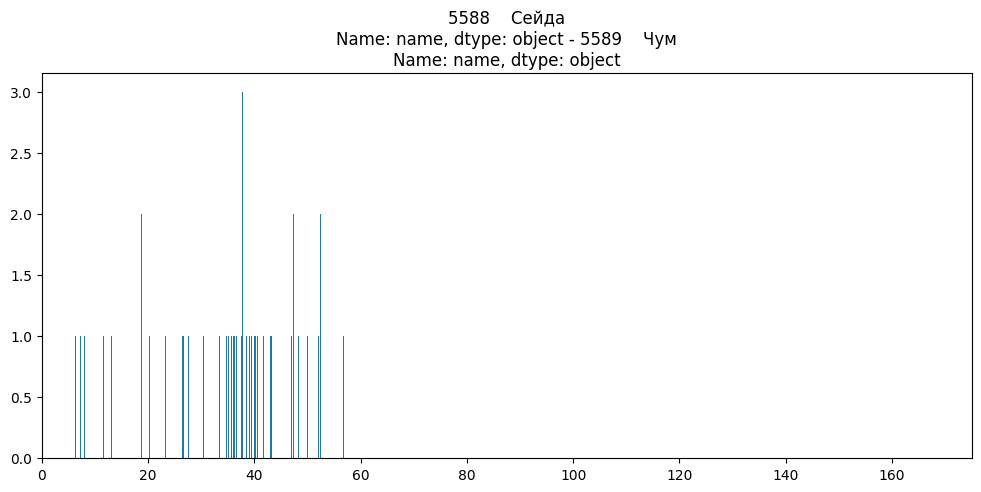

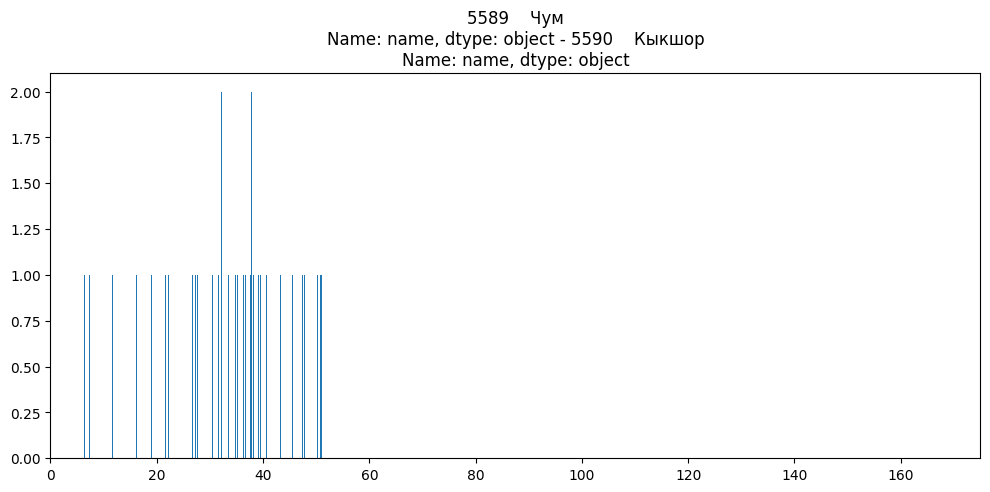

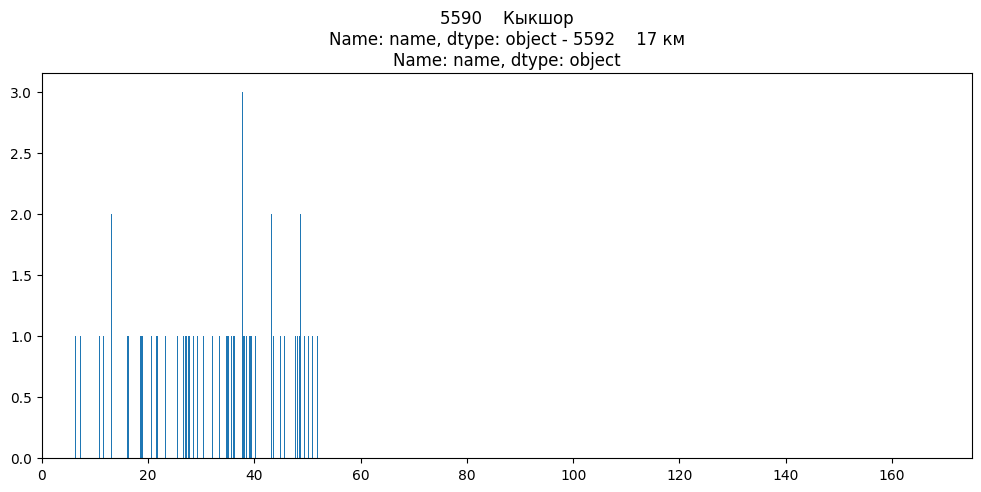

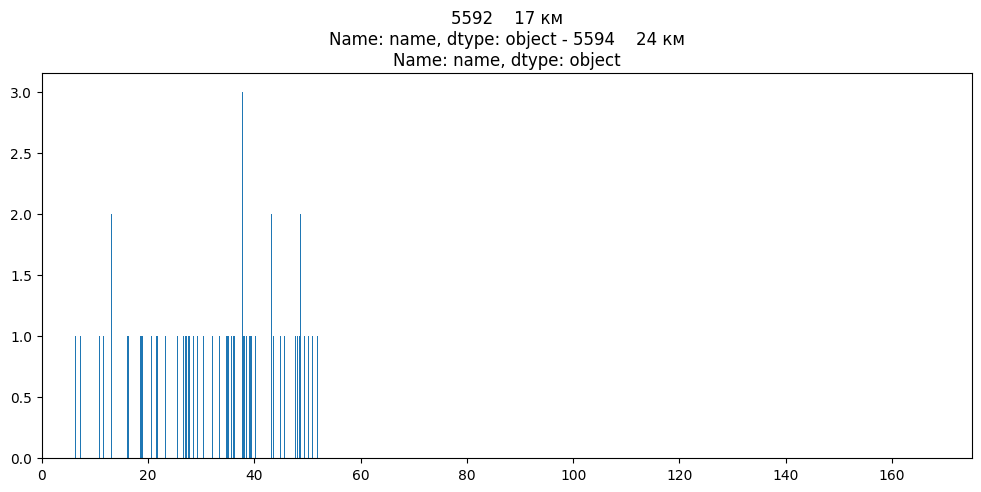

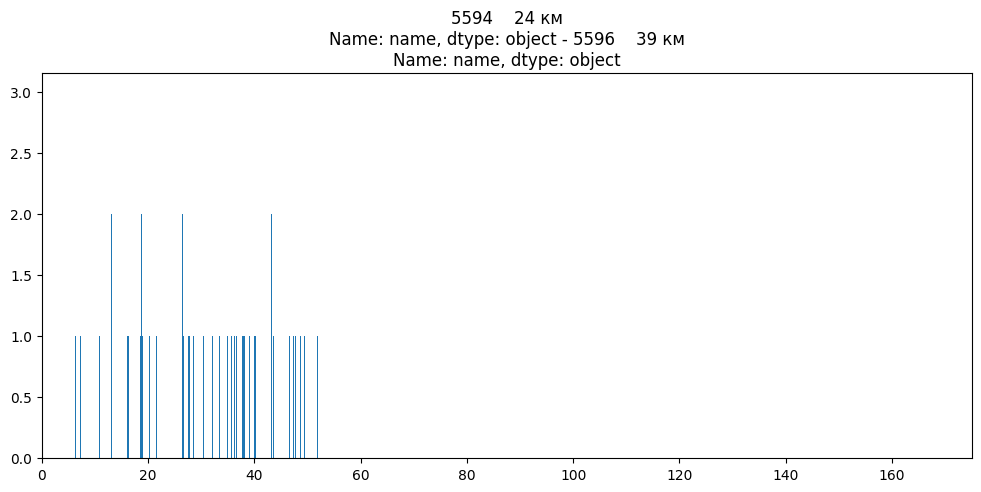

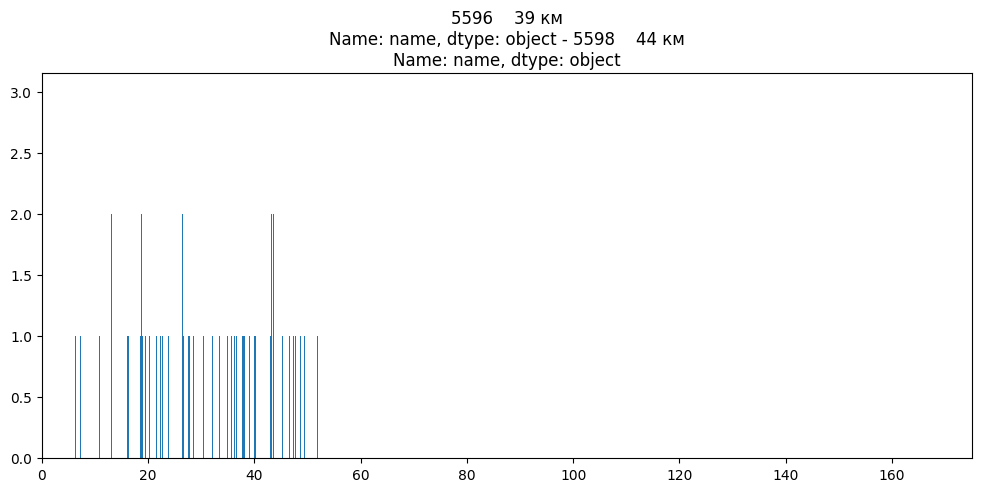

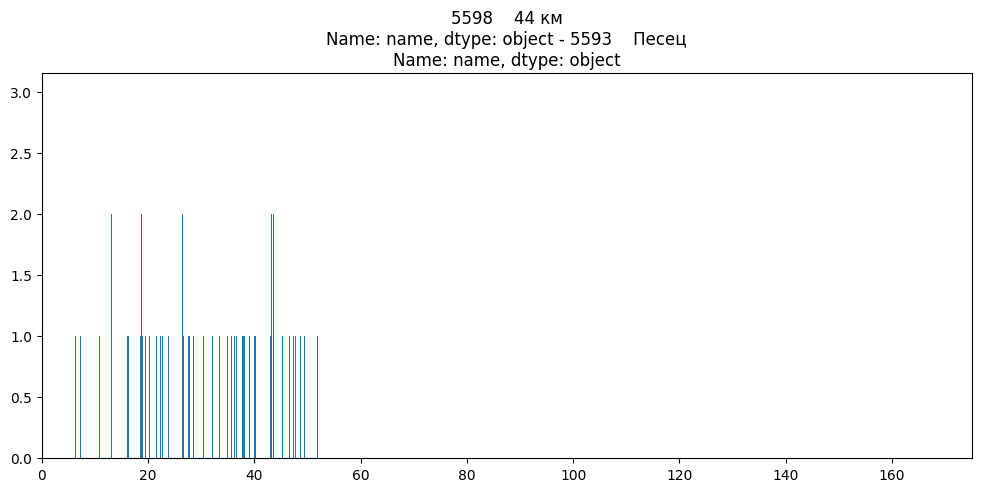

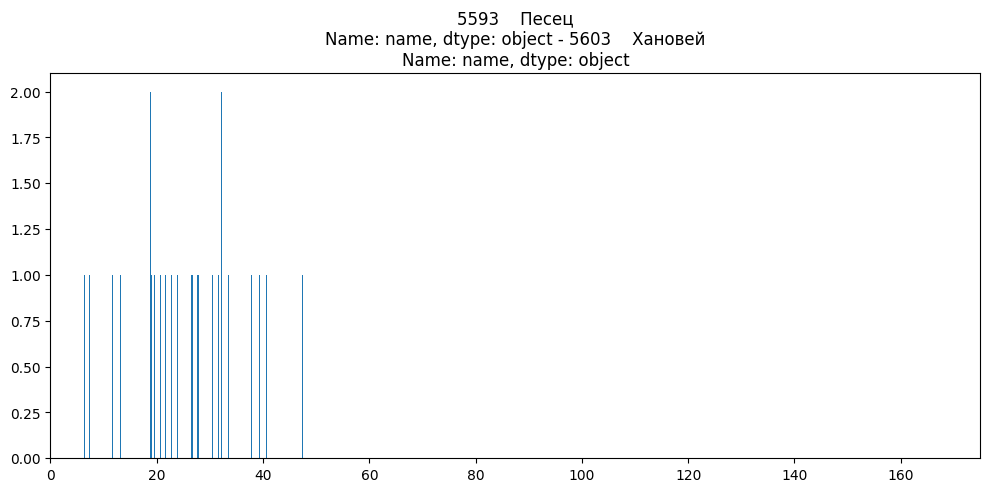

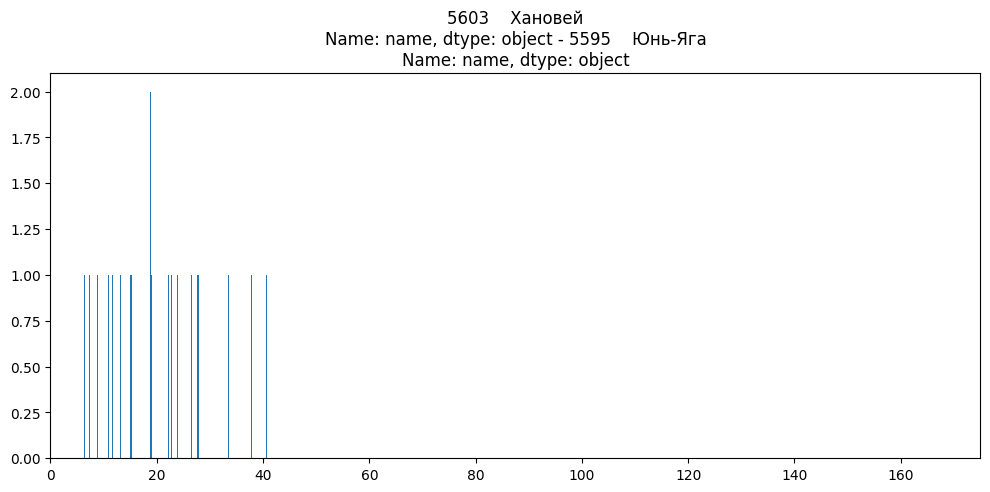

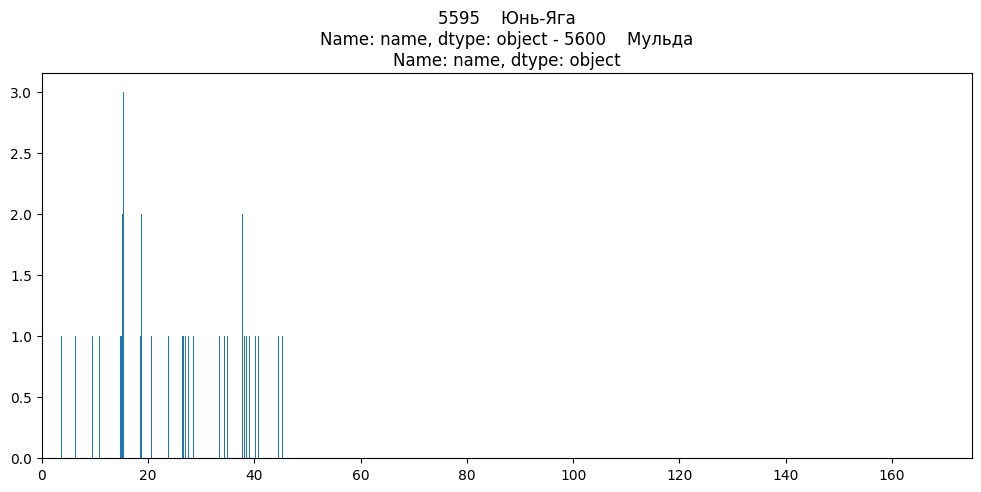

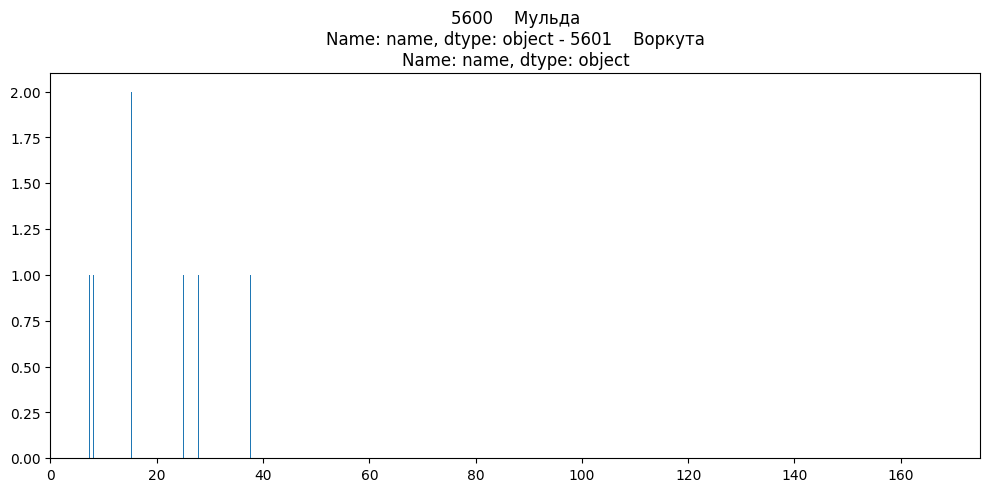

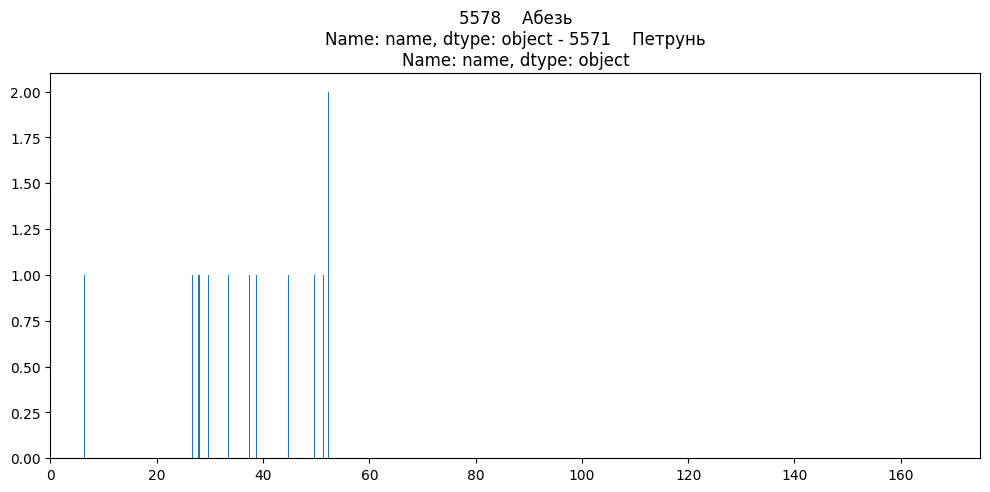

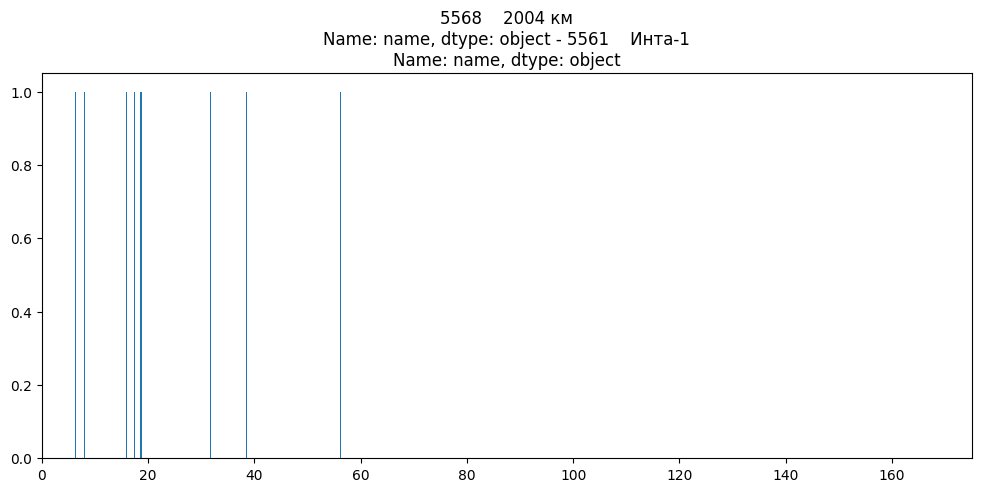

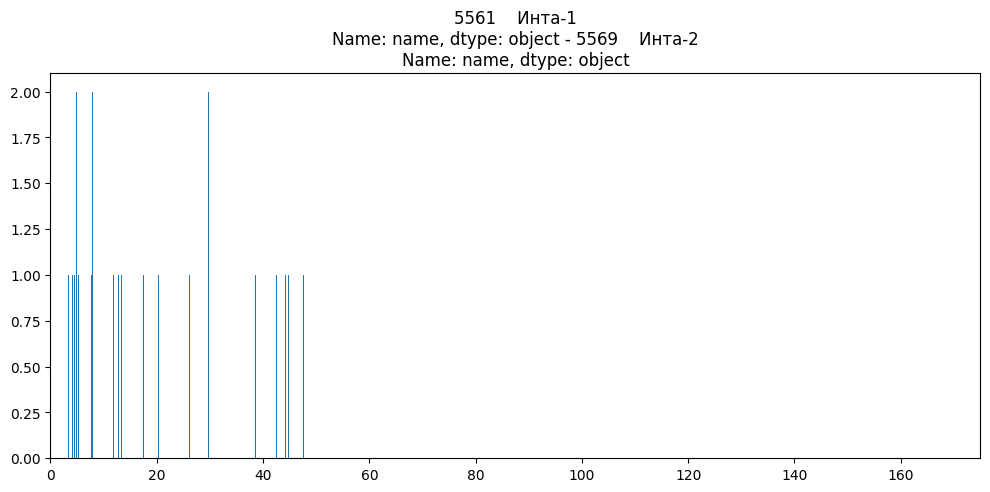

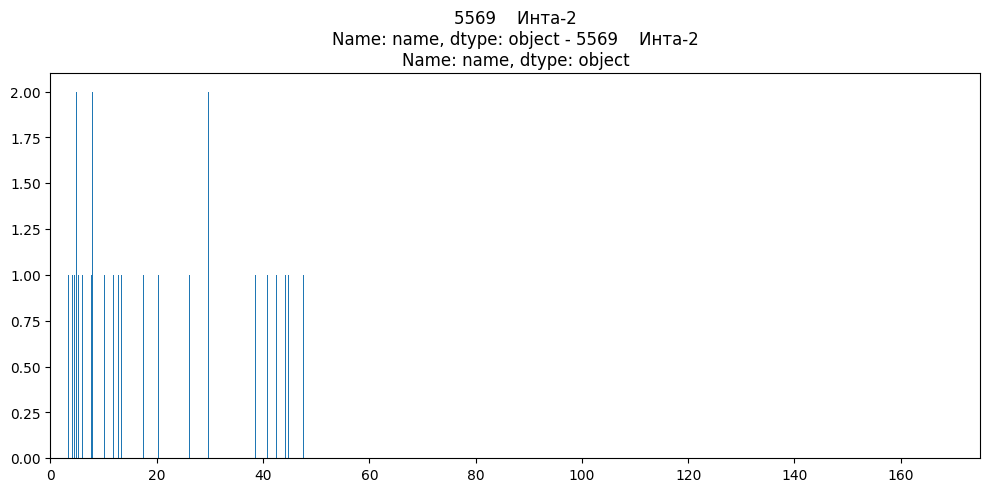

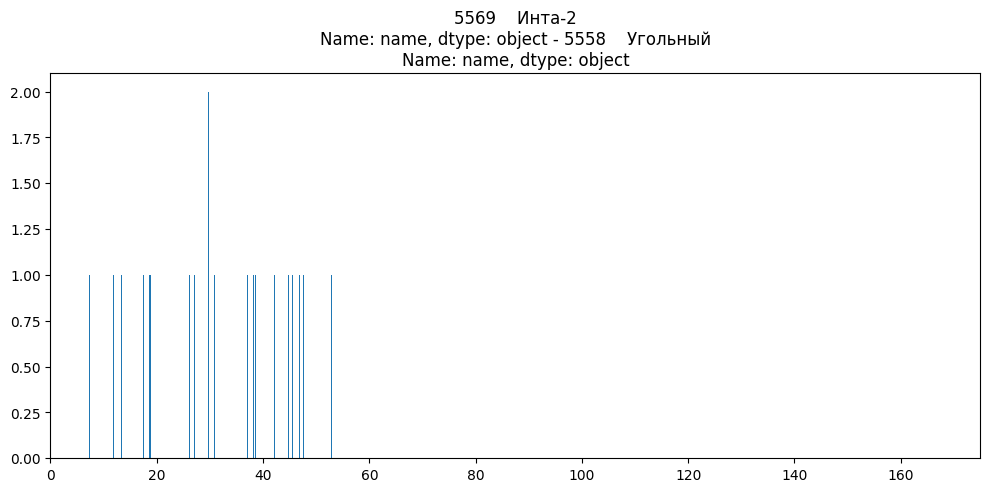

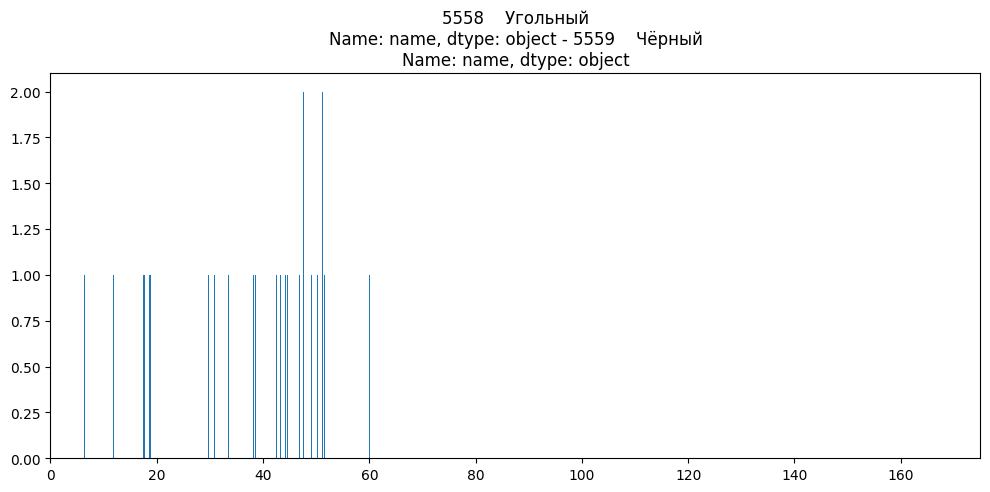

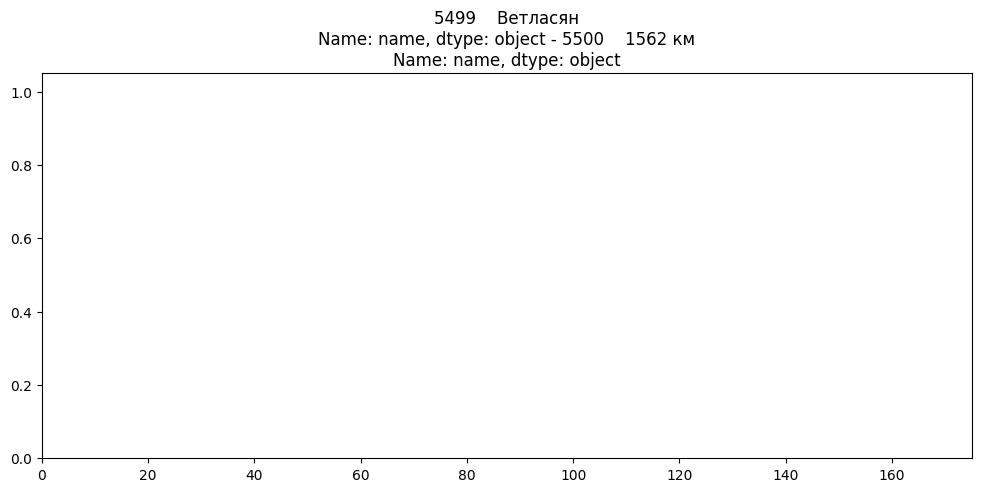

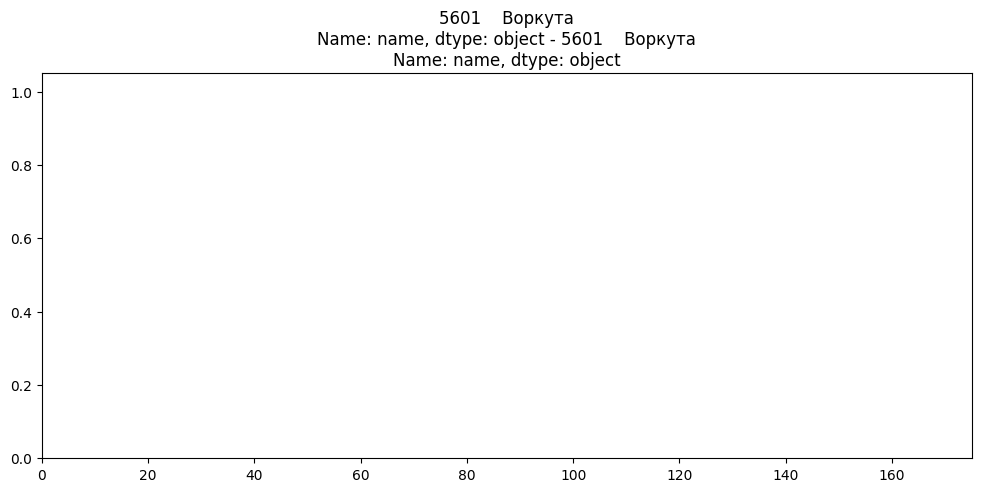

In [150]:
for i in avspeeds.keys(): 
    
    plt.figure(figsize = (12, 5))
    plt.hist(avspeeds[i], bins = 500)
    title = str(esr_coord[esr_coord.esr_id == i[0]].name) + ' - ' + str(esr_coord.name[esr_coord.esr_id == i[1]])
    plt.title(title)
    plt.xlim(0, 175)
    plt.show()

In [19]:
avspeed = {}

for key, val in avspeeds.items():
    
    avspeed[key] = np.percentile(val, 95)

In [108]:
avspeed.items()

dict_items([((285937, 286605), 47.377824349905666), ((286605, 286408), 57.41212018211542), ((286408, 286611), 57.264590720004385), ((286611, 286709), 57.13856511574391), ((286709, 286709), 60.594662597223696), ((286709, 286802), 59.58280237603588), ((286802, 286910), 62.57140576244863), ((286910, 287006), 62.62247364444219), ((287006, 286516), 65.07433159263368), ((286516, 287102), 63.01712282904807), ((287102, 287218), 62.567503374170705), ((287218, 287311), 62.94005008263125), ((287311, 287415), 62.5020669642901), ((287415, 287504), 61.526972140028754), ((287504, 287576), 63.46577690432206), ((287576, 287519), 65.05855867724993), ((287519, 287523), 70.8731692616678), ((287523, 287608), 61.87015239837563), ((287608, 287561), 65.367992882864), ((287561, 287720), 64.77350273935023), ((287720, 287557), 63.087389197627346), ((287557, 287542), 61.91491608107472), ((287542, 287881), 60.720889801777815), ((287881, 287805), 60.366545788001325), ((287805, 287858), 56.56913386470704), ((287858,

In [20]:
result = {'name_start': [], 'name_end': [], 'average_speed': [], 'latitude': []}

for key, val in avspeed.items():
    
    if key[0] != key[1]:
    
        result['name_start'].append(list(stations[stations.esr_id == key[0]].name)[0])
        result['name_end'].append(list(stations[stations.esr_id == key[1]].name)[0])
        result['latitude'].append(min(list(stations[stations.esr_id == key[1]].latitude)[0], 
                                      list(stations[stations.esr_id == key[0]].latitude)[0]))
        result['average_speed'].append(val)
    
res = pd.DataFrame(result)

In [21]:
res = res.sort_values(by='latitude').reset_index(drop=True)
res.head(50)

,name_start,name_end,average_speed,latitude
0,Пожня,Троицко-Печорск,57.455128,62.749055
1,Троицко-Печорск,Катыдведь,57.412120,62.749055
2,Сосногорск II,Пожня,47.604761,63.552696
3,Ветласян,1562 км,4.181305,63.573374
4,Катыдведь,Керки,57.390616,63.633717
5,Керки,Вис,57.820693,63.721627
6,Вис,Седьвож,62.311680,63.922535
7,Седьвож,Малая Пера,62.334739,64.080818
8,Малая Пера,Лемъю,63.353950,64.179604
9,Лемъю,Ираель,62.673542,64.250206


In [168]:
x = []
y = []
z = []

for i, row in res.iterrows():
    x.append(str(row.name_start)+'-'+str(row.name_end))
    y.append(row.average_speed)
    z.append(row.latitude)

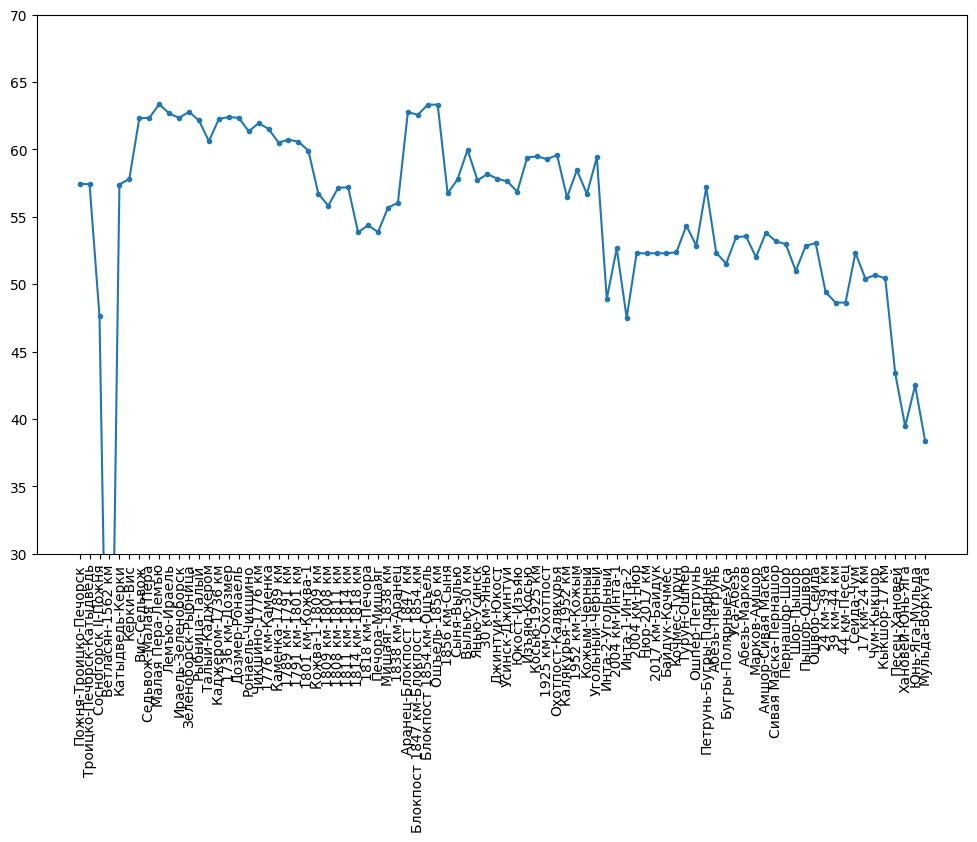

In [157]:
plt.figure(figsize=(12,7))
plt.plot(y, marker='.')
plt.xticks(range(len(x)), x, rotation=90)
plt.ylim(30, 70)
plt.show()

In [22]:
def momentum_average_intervals(data, esrs):

    speed_momentum = {}

    for i, row in tqdm(data.iterrows()):

        if row.speed > 5:

#             speeds_test.append(row.speed)
            last_esr = esrs.loc[0]
            for j, esr in esrs[1:].iterrows():

                if ( (row.latitude >= min(esr.latitude, last_esr.latitude)) and (row.latitude <= max(esr.latitude, last_esr.latitude)) and 
                (row.longitude >= min(esr.longitude, last_esr.longitude)) and (row.longitude <= max(esr.longitude, last_esr.longitude)) ):

                    if (last_esr.esr_id, esr.esr_id) in speed_momentum.keys():

                        speed_momentum[(last_esr.esr_id, esr.esr_id)].append(row.speed)

                    else:

                        speed_momentum[(last_esr.esr_id, esr.esr_id)] = [row.speed]

                last_esr = esr
    
    av_momentum = {}

    for interval, speeds in speed_momentum.items():
    
#         av_momentum[interval] = (sum(speeds) / len(speeds), 2)
        av_momentum[interval] = np.percentile(speeds, 95)
    return av_momentum, speed_momentum

In [23]:
momentum, _ = momentum_average_intervals(pure_df, stations)

11444it [00:07, 1462.87it/s]


In [24]:
result1 = {'name_start': [], 'name_end': [], 'average_speed': [], 'latitude': []}

for key, val in momentum.items():
    
    if key[0] != key[1]:
    
        result1['name_start'].append(list(stations[stations.esr_id == key[0]].name)[0])
        result1['name_end'].append(list(stations[stations.esr_id == key[1]].name)[0])
        result1['latitude'].append(min(list(stations[stations.esr_id == key[1]].latitude)[0], 
                                      list(stations[stations.esr_id == key[0]].latitude)[0]))
        result1['average_speed'].append(val)
    
res1 = pd.DataFrame(result1)

In [25]:
res1 = res1.sort_values(by='latitude').reset_index(drop=True)
res1

,name_start,name_end,average_speed,latitude
0,Сосногорск,Чомкосаель,38.760,63.363873
1,Ветласян,1562 км,5.500,63.573374
2,Пожня,Катыдведь,59.360,63.593002
3,Лемъю,Пожня,70.170,63.593002
4,Катыдведь,Керки,64.460,63.633717
...,...,...,...,...
71,Песец,24 км,45.300,67.060966
72,24 км,Юнь-Яга,54.425,67.060966
73,Чум,Кыкшор,56.080,67.091374
74,17 км,Песец,50.985,67.097481


In [188]:
x1 = []
y1 = []

for i, row in res1.iterrows():
    x1.append(row.latitude)
    y1.append(row.average_speed)

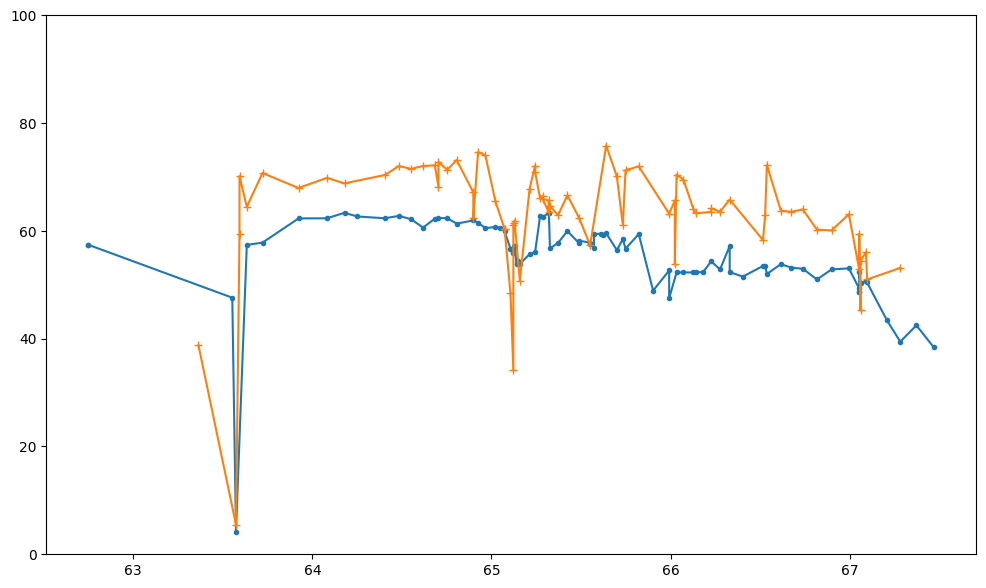

In [191]:
plt.figure(figsize=(12,7))
plt.plot(z, y, marker='.')
plt.plot(x1, y1, marker='+')
# plt.xticks(range(len(x)), x, rotation=90)
plt.ylim(0, 100)
plt.show()

In [26]:
stops = {'station': [], 'stops': []}
bugs = []

for dw in pure_df.id_dev_ut.unique():
    
    data = pure_df[pure_df.id_dev_ut == dw].sort_values(by='last_time').reset_index(drop=True)
    
    data = data[data.all_run > 0].reset_index(drop=True)
    
    last_row = data.loc[0]    
    
    for i, row in tqdm(data[1:].iterrows(), total=len(data)-1):
        
        time = (row.last_time - last_row.last_time) / 3600
            
        start = np.array((last_row.latitude, last_row.longitude))
        end = np.array((row.latitude, row.longitude))

        try:

            nods, dist = get_way(start, end)

        except:
            bugs.append(row)
            bugs.append(last_row)
            nods = []
            dist = 0

        station = []

        for nod in nods:

            if nod in osm_esr_conf.keys():

                station.append(osm_esr_conf[nod])  

        if len(station) == 1:
            
            stat = list(stations[stations.esr_id == station[0]].name)[0]
            
            if stat in list(res1.name_start):
                
                speed = list(res1[res1.name_start == stat].average_speed)[0]
                distance = speed * time
                delay = (distance - dist) / speed
                
            elif stat in list(res1.name_end):
                
                speed1 = list(res1[res1.name_end == stat].average_speed)[0]
                distance1 = speed1 * time
                delay = (distance1 - dist) / speed1


#         for inter in intervals:

#             stops['interval'].append(inter)
#             stops['speed'].append(speed)

            stops['station'].append(station[0])
            stops['stops'].append(delay)


        last_row = row

100%|████████████████████████████████████████████████████████████████████████████████| 751/751 [01:27<00:00,  8.58it/s]


In [28]:
stops = pd.DataFrame(stops)

In [43]:
stops['stop_name'] = [list(stations[stations.esr_id == stops.loc[i, 'station']].name)[0] for i in range(len(stops))]

In [51]:
stops['latitude'] = [list(stations[stations.esr_id == stops.loc[i, 'station']].latitude)[0] for i in range(len(stops))]

In [53]:
stops = stops.sort_values(by='latitude').reset_index(drop=True)

In [58]:
forplot = stops.groupby(by='station').agg({'stops': 'sum', 'stop_name': 'first', 'latitude': 'first'})

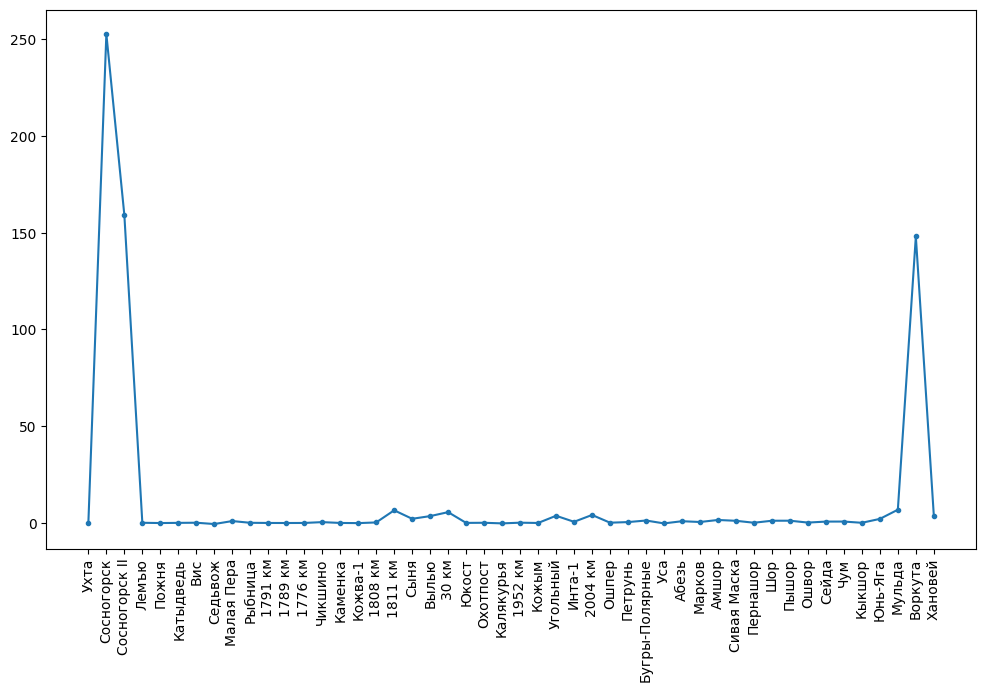

In [60]:
plt.figure(figsize=(12,7))
plt.plot(forplot.stop_name, forplot.stops, marker='.')
plt.xticks(rotation=90)
plt.show()

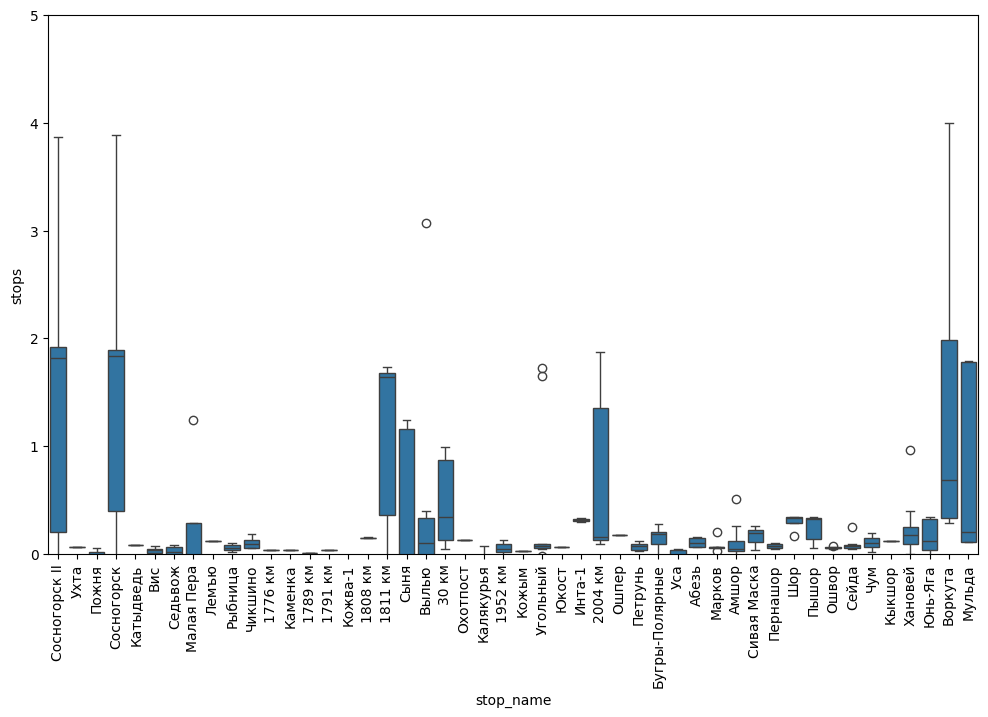

In [55]:
plt.figure(figsize=(12,7))
sns.boxplot(stops, x='stop_name', y='stops')

plt.xticks(rotation=90)
plt.ylim(0, 5)
plt.show()

In [63]:
pure_df.id_dev_ut.unique()

array(['dwtest22', 'dwtest26', 'dwtest27', 'dwtest16', 'dwtest15',
       'dwtest23', 'dwtest17', 'dwtest24'], dtype=object)

In [81]:
regular = {'station': [], 'stops': []}
bugs = []

for dw in pure_df.id_dev_ut.unique():
    
#     if dw != 'dwtest22':
        
#         continue
    
    data = pure_df[pure_df.id_dev_ut == dw].sort_values(by='last_time').reset_index(drop=True)
    
    data = data[data.all_run > 0].reset_index(drop=True)
    
    last_row = data.loc[0]    
    
    for i, row in tqdm(data[1:].iterrows(), total=len(data)-1):
        
        time = (row.last_time - last_row.last_time) / 3600
            
        start = np.array((last_row.latitude, last_row.longitude))
        end = np.array((row.latitude, row.longitude))

        try:

            nods, dist = get_way(start, end)

        except:
            bugs.append(row)
            bugs.append(last_row)
            nods = []
            dist = 0

        station = []
        speeds = []

        for nod in nods:

            if nod in osm_esr_conf.keys():

                station.append(osm_esr_conf[nod])
        
        if len(station) == 0:
            
            last_row = row
            continue
            
        for st in station:
            
            stat = list(stations[stations.esr_id == st].name)[0]
            
            speed1 = list(res1[res1.name_end == stat].average_speed)
            if len(speed1) > 0:
                speed1 = speed1[0]
            else:
                continue
            speed2 = list(res1[res1.name_start == stat].average_speed)
            if len(speed2) > 0:
                speed2 = speed2[0]
            else:
                continue
            speed = (speed1 + speed2) / 2
            
            speeds.append(speed)
        
        if len(speeds) == 0:
            
            last_row = row
            continue
            
        average = sum(speeds) / len(speeds)
        delay = time - dist / average
        
    #         for inter in intervals:

    #             stops['interval'].append(inter)
    #             stops['speed'].append(speed)

        regular['station'].append(station)
        regular['stops'].append(delay)


        last_row = row

100%|████████████████████████████████████████████████████████████████████████████████| 751/751 [01:24<00:00,  8.85it/s]


In [70]:
pd.DataFrame(regular)

,station,stops
0,"[285937, 286605, 286408, 286611, 286709, 28670...",107.495858
1,"[288687, 288615, 288672, 288627, 288634, 28885...",3.619318
2,"[289321, 289529, 289213, 289374, 289355, 28922...",0.518895
3,"[289035, 289020, 289016, 289001, 288946, 28892...",0.756325
4,"[288831, 288827, 288850]",1.020718
5,"[288634, 288627, 288672, 288615, 288687]",1.475690
6,"[288600, 288704, 288704]",1.947321
7,"[288530, 288530, 288507, 288437, 288422, 28841...",2.206032
8,"[287817, 287858, 287805, 287881, 287542, 28755...",1.756950
9,"[286516, 287006, 286910, 286802, 286709, 28670...",0.527851


In [82]:
new = {'station': [], 'stops': []}

for stat, stop in zip(regular['station'], regular['stops']):
    
    for st in stat:
        
        new['station'].append(st)
        new['stops'].append(stop)
            


In [83]:
resdf = pd.DataFrame(new)
resdf['stop_name'] = [list(stations[stations.esr_id == resdf.loc[i, 'station']].name)[0] for i in range(len(resdf))]
resdf['latitude'] = [list(stations[stations.esr_id == resdf.loc[i, 'station']].latitude)[0] for i in range(len(resdf))]
resdf = resdf.sort_values(by='latitude').reset_index(drop=True)

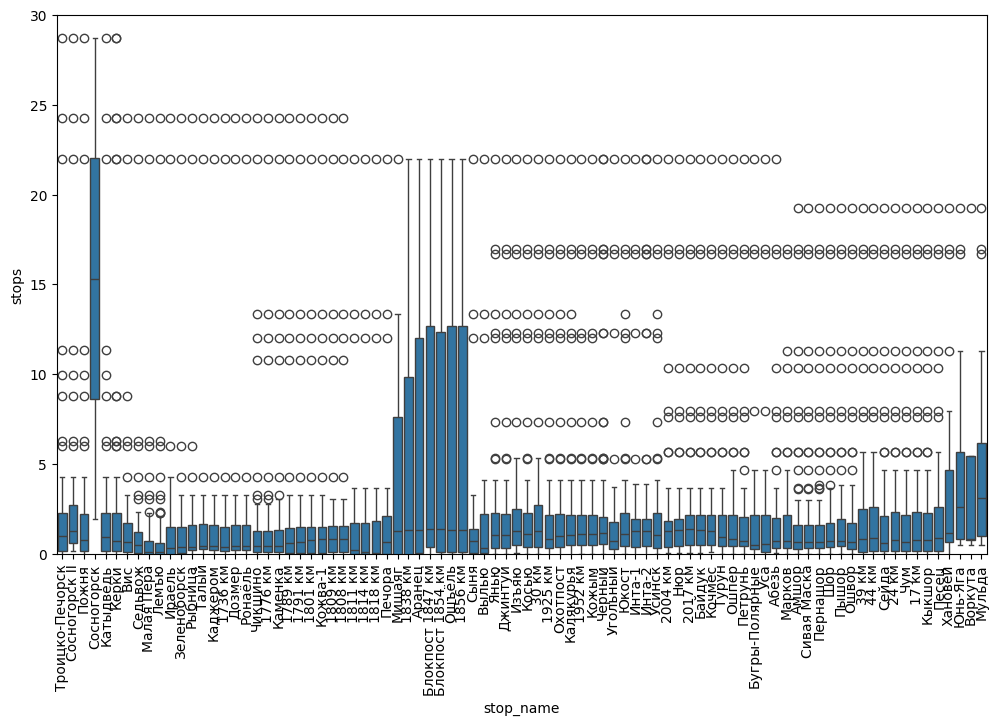

In [85]:
plt.figure(figsize=(12,7))
sns.boxplot(resdf, x='stop_name', y='stops')

plt.xticks(rotation=90)
plt.ylim(0, 30)
plt.show()